# 🎵 Spotify Review Sentiment Analysis

## Analisis Sentimen Review Aplikasi Spotify dari Google Play Store

### Overview Proyek:
- **Dataset**: Review aplikasi Spotify hasil scraping mandiri
- **Target**: Klasifikasi sentimen 3 kelas (Positif, Netral, Negatif)
- **Jumlah Data**: 10,000+ review (2,000 per rating)
- **Algoritma**: Multiple ML/DL approaches
- **Target Akurasi**: >92% (training & testing)

### Tahapan:
1. **Data Loading & Exploration**
2. **Data Cleaning & Preprocessing** 
3. **Feature Extraction & Labeling**
4. **Model Training (3 Experiments)**
5. **Model Evaluation & Testing**
6. **Inference Testing**

## 📦 Import Libraries

In [1]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np
import json
import re
import warnings
warnings.filterwarnings('ignore')

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Machine Learning Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
# Download required NLTK data
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

print("✅ NLTK data downloaded successfully!")

✅ NLTK data downloaded successfully!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raipr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raipr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raipr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\raipr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\raipr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 📁 1. Data Loading & Exploration

In [3]:
# Load dataset from scraping results
import os
import glob

def load_spotify_reviews():
    """Load all Spotify review files from dataset folder"""
    
    # Try to find CSV files first
    csv_pattern = os.path.join('dataset', 'csv', 'spotify_reviews_*.csv')
    csv_files = glob.glob(csv_pattern)
    
    if csv_files:
        print(f"📁 Found {len(csv_files)} CSV files")
        dfs = []
        for file in csv_files:
            df = pd.read_csv(file)
            print(f"   - {os.path.basename(file)}: {len(df)} reviews")
            dfs.append(df)
        
        combined_df = pd.concat(dfs, ignore_index=True)
        return combined_df
    
    # Fallback to JSON files
    json_pattern = os.path.join('dataset', 'json', 'spotify_reviews_*.json')
    json_files = glob.glob(json_pattern)
    
    if json_files:
        print(f"📁 Found {len(json_files)} JSON files")
        all_reviews = []
        for file in json_files:
            with open(file, 'r', encoding='utf-8') as f:
                reviews = json.load(f)
                print(f"   - {os.path.basename(file)}: {len(reviews)} reviews")
                all_reviews.extend(reviews)
        
        return pd.DataFrame(all_reviews)
    
    raise FileNotFoundError("No review files found in dataset folder!")

# Load data
print("🔄 Loading Spotify review dataset...")
df = load_spotify_reviews()
print(f"✅ Loaded {len(df)} total reviews")

# Display basic info
print("\n📊 Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

🔄 Loading Spotify review dataset...
📁 Found 1 CSV files
   - spotify_reviews_20250909_125148.csv: 15000 reviews
✅ Loaded 15000 total reviews

📊 Dataset Info:
Shape: (15000, 11)
Columns: ['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'replyAt', 'appVersion']


🔍 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              15000 non-null  object 
 1   userName              15000 non-null  object 
 2   userImage             15000 non-null  object 
 3   content               14999 non-null  object 
 4   score                 15000 non-null  int64  
 5   thumbsUpCount         15000 non-null  int64  
 6   reviewCreatedVersion  12484 non-null  object 
 7   at                    15000 non-null  object 
 8   replyContent          3800 non-null   object 
 9   replyAt               0 non-null      float64
 10  appVersion            12484 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 1.3+ MB

📈 First 5 rows:


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,replyAt,appVersion
0,1aaae595-d09a-446e-aca5-581e6547dac5,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"free version of the app feels like malware, cl...",1,0,8.8.80.599,2025-09-08 12:46:59,Hey! We hear you and we'll pass your feedback ...,NaN,8.8.80.599
1,4c2dcf3e-ef07-4d3d-bbed-42f783867817,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,smv♥️,1,0,NaN,2025-09-08 12:38:15,NaN,NaN,NaN
2,9f194ccc-48ad-4b0c-85a5-41dc09fceb52,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,У меня samsung z flip 5. Последнюю неделю спот...,1,0,9.0.76.1126,2025-09-08 12:29:42,Здравствуйте. Нам очень жаль это слышать. Вы п...,NaN,9.0.76.1126
3,15ad5484-1304-4845-b32c-703668e33a87,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Third class app only ad app not a music app wo...,1,0,9.0.74.1121,2025-09-08 12:25:29,NaN,NaN,9.0.74.1121
4,26bf2b7b-67b9-4e3a-ac45-43af8b12acdf,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,sidhu ke song delete kiye hai isiliye mai Spot...,1,0,9.0.76.1126,2025-09-08 12:23:48,NaN,NaN,9.0.76.1126



📊 Rating Distribution:
score
1    3000
2    3000
3    3000
4    3000
5    3000
Name: count, dtype: int64


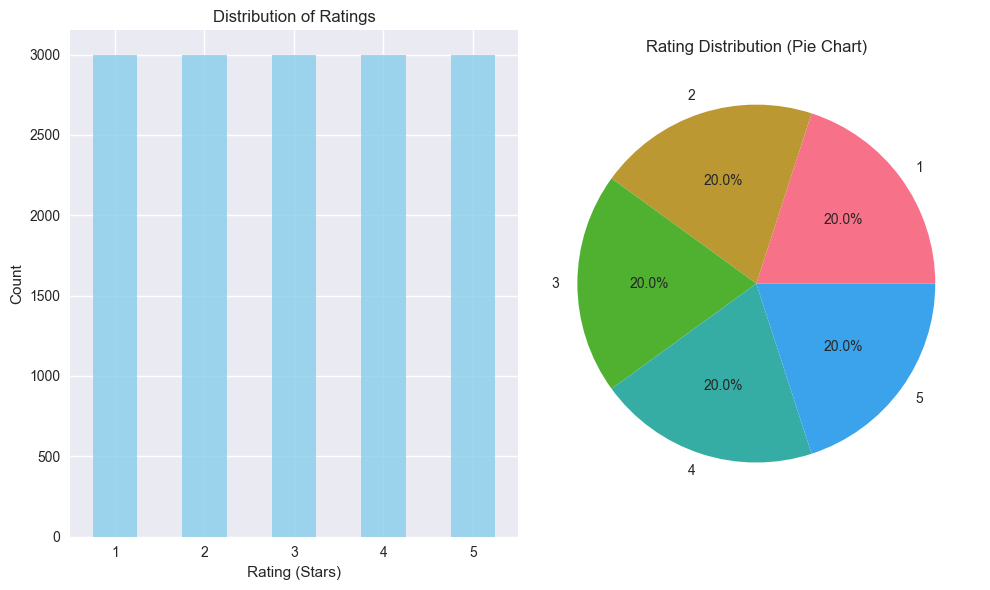

In [4]:
# Explore dataset structure
print("🔍 Dataset Overview:")
print("=" * 50)
df.info()

print("\n📈 First 5 rows:")
print("=" * 50)
display(df.head())

print("\n📊 Rating Distribution:")
print("=" * 50)
rating_dist = df['score'].value_counts().sort_index()
print(rating_dist)

# Visualize rating distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
rating_dist.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Distribution of Ratings')
plt.xlabel('Rating (Stars)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(rating_dist.values, labels=rating_dist.index, autopct='%1.1f%%')
plt.title('Rating Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

In [5]:
# Check for missing values and data quality
print("🔍 Data Quality Check:")
print("=" * 50)
print("Missing values:")
print(df.isnull().sum())

print("\nEmpty content:")
empty_content = df['content'].isna() | (df['content'] == '') | (df['content'] == 'None')
print(f"Empty reviews: {empty_content.sum()}")

print("\nReview length statistics:")
df['content_length'] = df['content'].astype(str).str.len()
print(df['content_length'].describe())

# Sample reviews for each rating
print("\n📝 Sample Reviews by Rating:")
print("=" * 50)
for rating in sorted(df['score'].unique()):
    sample_review = df[df['score'] == rating]['content'].iloc[0]
    print(f"Rating {rating}: {sample_review[:100]}...")
    print()

🔍 Data Quality Check:
Missing values:
reviewId                    0
userName                    0
userImage                   0
content                     1
score                       0
thumbsUpCount               0
reviewCreatedVersion     2516
at                          0
replyContent            11200
replyAt                 15000
appVersion               2516
dtype: int64

Empty content:
Empty reviews: 1

Review length statistics:
count    15000.000000
mean       111.104733
std        127.057325
min          1.000000
25%         19.000000
50%         59.000000
75%        155.000000
max        500.000000
Name: content_length, dtype: float64

📝 Sample Reviews by Rating:
Rating 1: free version of the app feels like malware, click anything on the screen and you get 60 seconds of a...

Rating 2: always showing to take premium and it is not playing our songs if we do not take premium...

Rating 3: song collections can be more...

Rating 4: love the 💙 Blues n rock so play On...

Rating 

## 🧹 2. Data Cleaning & Preprocessing

In [6]:
# Enhanced Text Preprocessing with Advanced Techniques
import re
import string
from textblob import TextBlob
from collections import Counter

def enhanced_clean_text(text):
    """Enhanced text cleaning with comprehensive preprocessing"""
    if pd.isna(text) or text == 'None' or text == '':
        return ''
    
    # Convert to string and preserve original for length calculation
    original_text = str(text)
    text = original_text.lower()
    
    # Handle contractions more comprehensively
    contractions = {
        "won't": "will not", "can't": "cannot", "shouldn't": "should not",
        "wouldn't": "would not", "couldn't": "could not", "mustn't": "must not",
        "needn't": "need not", "daren't": "dare not", "mayn't": "may not",
        "shan't": "shall not", "mightn't": "might not",
        "n't": " not", "'re": " are", "'ve": " have", "'ll": " will", 
        "'d": " would", "'m": " am", "'s": " is",
        "let's": "let us", "that's": "that is", "who's": "who is",
        "what's": "what is", "where's": "where is", "when's": "when is",
        "why's": "why is", "how's": "how is", "there's": "there is",
        "here's": "here is", "it's": "it is", "he's": "he is",
        "she's": "she is", "we're": "we are", "they're": "they are",
        "i'm": "i am", "you're": "you are", "we've": "we have",
        "they've": "they have", "i've": "i have", "you've": "you have",
        "we'll": "we will", "they'll": "they will", "i'll": "i will",
        "you'll": "you will", "he'll": "he will", "she'll": "she will",
        "we'd": "we would", "they'd": "they would", "i'd": "i would",
        "you'd": "you would", "he'd": "he would", "she'd": "she would"
    }
    
    # Apply contractions
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    
    # Remove URLs (more comprehensive)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove mentions and hashtags but keep the word
    text = re.sub(r'@(\w+)', r'\1', text)  # @spotify -> spotify
    text = re.sub(r'#(\w+)', r'\1', text)  # #music -> music
    
    # Handle emojis and special Unicode characters
    # Keep emoticons that might be sentiment-relevant
    emoticons = r'[=:;][oO\-]?[D\)\]\(\[/\\OpP]'
    text = re.sub(emoticons, ' EMOTICON ', text)
    
    # Remove non-ASCII characters but preserve spaces
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # Replace multiple punctuation with single
    text = re.sub(r'[!]{2,}', ' EXCLAMATION ', text)  # Multiple ! -> EXCLAMATION
    text = re.sub(r'[?]{2,}', ' QUESTION ', text)     # Multiple ? -> QUESTION
    text = re.sub(r'[.]{2,}', ' DOTS ', text)         # Multiple . -> DOTS
    
    # Handle elongated words (looooove -> love)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    
    # Remove extra punctuation but keep sentence structure
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove standalone numbers but keep alphanumeric
    text = re.sub(r'\b\d+\b', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def advanced_text_preprocessing(text):
    """Advanced text preprocessing with enhanced NLP techniques"""
    if not text or len(text.strip()) == 0:
        return ''
    
    try:
        # Tokenization
        tokens = word_tokenize(text)
        
        # Remove stopwords but keep sentiment-important ones
        stop_words = set(stopwords.words('english'))
        # Keep important words that might indicate sentiment
        sentiment_stopwords = {'not', 'no', 'nor', 'but', 'however', 'although', 'though', 'yet', 'except'}
        stop_words = stop_words - sentiment_stopwords
        
        # Filter tokens
        tokens = [token for token in tokens if token.lower() not in stop_words and len(token) > 1]
        
        # Remove tokens that are just punctuation
        tokens = [token for token in tokens if not all(c in string.punctuation for c in token)]
        
        # Lemmatization with POS tagging for better accuracy
        lemmatizer = WordNetLemmatizer()
        
        def get_wordnet_pos(word):
            """Map POS tag to first character lemmatize() accepts"""
            from nltk.corpus import wordnet
            tag = nltk.pos_tag([word])[0][1][0].upper()
            tag_dict = {"J": wordnet.ADJ,
                       "N": wordnet.NOUN,
                       "V": wordnet.VERB,
                       "R": wordnet.ADV}
            return tag_dict.get(tag, wordnet.NOUN)
        
        # Apply lemmatization with POS tagging
        processed_tokens = []
        for token in tokens:
            try:
                pos = get_wordnet_pos(token)
                lemmatized = lemmatizer.lemmatize(token.lower(), pos)
                processed_tokens.append(lemmatized)
            except:
                processed_tokens.append(token.lower())
        
        # Remove very short and very long tokens
        processed_tokens = [token for token in processed_tokens if 2 <= len(token) <= 20]
        
        # Join tokens back
        result = ' '.join(processed_tokens)
        
        return result
        
    except Exception as e:
        print(f"Error processing text: {e}")
        return text

def create_text_features(df):
    """Create additional text-based features for better model performance"""
    
    print("🔧 Creating advanced text features...")
    
    # Basic text statistics
    df['text_length'] = df['content'].astype(str).str.len()
    df['word_count'] = df['content_processed'].str.split().str.len()
    df['avg_word_length'] = df['content_processed'].apply(
        lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
    )
    
    # Punctuation and capitalization features
    df['exclamation_count'] = df['content'].astype(str).str.count('!')
    df['question_count'] = df['content'].astype(str).str.count('\?')
    df['caps_count'] = df['content'].astype(str).str.count('[A-Z]')
    df['caps_ratio'] = df['caps_count'] / (df['text_length'] + 1)  # +1 to avoid division by zero
    
    # Sentiment indicators from original text
    positive_indicators = ['love', 'great', 'awesome', 'amazing', 'perfect', 'excellent', 
                          'fantastic', 'wonderful', 'best', 'good', 'nice', 'beautiful',
                          'brilliant', 'outstanding', 'superb', 'terrific', 'marvelous']
    
    negative_indicators = ['hate', 'terrible', 'awful', 'horrible', 'worst', 'bad', 'poor',
                          'disappointing', 'useless', 'annoying', 'frustrating', 'sucks',
                          'pathetic', 'disgusting', 'ridiculous', 'waste', 'boring']
    
    # Count sentiment words
    df['positive_words'] = df['content_processed'].apply(
        lambda x: sum(1 for word in positive_indicators if word in x.lower().split())
    )
    
    df['negative_words'] = df['content_processed'].apply(
        lambda x: sum(1 for word in negative_indicators if word in x.lower().split())
    )
    
    # Sentiment ratio
    df['sentiment_ratio'] = (df['positive_words'] - df['negative_words']) / (df['word_count'] + 1)
    
    # Readability and complexity features
    try:
        import textstat
        df['flesch_reading_ease'] = df['content'].apply(
            lambda x: textstat.flesch_reading_ease(str(x)) if pd.notna(x) else 0
        )
        df['flesch_kincaid_grade'] = df['content'].apply(
            lambda x: textstat.flesch_kincaid_grade(str(x)) if pd.notna(x) else 0
        )
    except ImportError:
        print("⚠️ textstat not available, skipping readability features")
        df['flesch_reading_ease'] = 0
        df['flesch_kincaid_grade'] = 0
    
    # Text complexity
    df['unique_words'] = df['content_processed'].apply(
        lambda x: len(set(x.split())) if x else 0
    )
    df['lexical_diversity'] = df['unique_words'] / (df['word_count'] + 1)
    
    return df

def detect_and_handle_duplicates(df):
    """Detect and handle duplicate reviews"""
    
    print("🔍 Detecting and handling duplicates...")
    
    # Check for exact duplicates
    exact_duplicates = df.duplicated(subset=['content'], keep='first').sum()
    print(f"Found {exact_duplicates} exact duplicate reviews")
    
    # Check for near-duplicates (same content but different formatting)
    df['content_normalized'] = df['content_processed'].str.replace(' ', '').str.lower()
    near_duplicates = df.duplicated(subset=['content_normalized'], keep='first').sum()
    print(f"Found {near_duplicates} near-duplicate reviews")
    
    # Remove duplicates
    df_clean = df.drop_duplicates(subset=['content_normalized'], keep='first')
    df_clean = df_clean.drop(columns=['content_normalized'])
    
    removed_count = len(df) - len(df_clean)
    print(f"Removed {removed_count} duplicate reviews")
    
    return df_clean

def handle_class_imbalance(df, target_col='sentiment', method='hybrid'):
    """Handle class imbalance with various techniques"""
    
    print("⚖️ Handling class imbalance...")
    
    # Check current distribution
    class_dist = df[target_col].value_counts()
    print("Current class distribution:")
    print(class_dist)
    print(f"Imbalance ratio: {class_dist.max() / class_dist.min():.2f}")
    
    if method == 'oversample':
        # Simple oversampling
        max_size = class_dist.max()
        balanced_dfs = []
        
        for sentiment in df[target_col].unique():
            sentiment_df = df[df[target_col] == sentiment]
            if len(sentiment_df) < max_size:
                # Oversample minority class
                oversampled_df = sentiment_df.sample(n=max_size, replace=True, random_state=42)
                balanced_dfs.append(oversampled_df)
            else:
                balanced_dfs.append(sentiment_df)
        
        balanced_df = pd.concat(balanced_dfs, ignore_index=True)
        
    elif method == 'undersample':
        # Simple undersampling
        min_size = class_dist.min()
        balanced_dfs = []
        
        for sentiment in df[target_col].unique():
            sentiment_df = df[df[target_col] == sentiment]
            undersampled_df = sentiment_df.sample(n=min_size, random_state=42)
            balanced_dfs.append(undersampled_df)
        
        balanced_df = pd.concat(balanced_dfs, ignore_index=True)
        
    elif method == 'hybrid':
        # Hybrid approach: moderate balancing
        median_size = int(class_dist.median())
        target_size = min(median_size * 2, class_dist.max())  # Don't go too extreme
        
        balanced_dfs = []
        for sentiment in df[target_col].unique():
            sentiment_df = df[df[target_col] == sentiment]
            current_size = len(sentiment_df)
            
            if current_size < target_size:
                # Oversample smaller classes
                balanced_df = sentiment_df.sample(n=target_size, replace=True, random_state=42)
            elif current_size > target_size * 1.5:
                # Slightly undersample very large classes
                balanced_df = sentiment_df.sample(n=int(target_size * 1.2), random_state=42)
            else:
                balanced_df = sentiment_df
            
            balanced_dfs.append(balanced_df)
        
        balanced_df = pd.concat(balanced_dfs, ignore_index=True)
    
    else:
        balanced_df = df
    
    # Show new distribution
    new_dist = balanced_df[target_col].value_counts()
    print("\nNew class distribution:")
    print(new_dist)
    print(f"New imbalance ratio: {new_dist.max() / new_dist.min():.2f}")
    
    return balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

def quality_filter(df, min_word_count=3, max_word_count=500):
    """Filter out low-quality reviews"""
    
    print(f"🔍 Filtering reviews with quality criteria...")
    
    initial_count = len(df)
    
    # Filter by word count
    df_filtered = df[
        (df['word_count'] >= min_word_count) & 
        (df['word_count'] <= max_word_count)
    ].copy()
    
    # Filter out reviews that are mostly punctuation or numbers
    df_filtered = df_filtered[
        df_filtered['content_processed'].str.len() > 10
    ].copy()
    
    # Filter out reviews with too many repeated characters
    df_filtered = df_filtered[
        ~df_filtered['content'].str.contains(r'(.)\1{10,}', regex=True, na=False)
    ].copy()
    
    # Filter out reviews that are mostly in caps (likely spam)
    df_filtered = df_filtered[
        df_filtered['caps_ratio'] < 0.8
    ].copy()
    
    removed_count = initial_count - len(df_filtered)
    print(f"Removed {removed_count} low-quality reviews ({removed_count/initial_count*100:.1f}%)")
    
    return df_filtered

# Apply enhanced preprocessing
print("🧹 ENHANCED DATA CLEANING & PREPROCESSING")
print("=" * 60)

# Step 1: Enhanced text cleaning
print("\n1️⃣ Enhanced text cleaning...")
df['content_cleaned'] = df['content'].apply(enhanced_clean_text)

# Step 2: Advanced text preprocessing
print("\n2️⃣ Advanced text preprocessing...")
df['content_processed'] = df['content_cleaned'].apply(advanced_text_preprocessing)

# Step 3: Create additional features
df = create_text_features(df)

# Step 4: Quality filtering
df = quality_filter(df)

# Step 5: Handle duplicates
df = detect_and_handle_duplicates(df)

# Step 6: Remove completely empty reviews after processing
initial_count = len(df)
df = df[df['content_processed'].str.len() > 0].copy()
empty_removed = initial_count - len(df)
if empty_removed > 0:
    print(f"\n🗑️ Removed {empty_removed} empty reviews after processing")

print(f"\n✅ Enhanced preprocessing completed!")
print(f"📊 Final dataset: {len(df)} reviews")

# Show preprocessing examples
print("\n📝 Enhanced Preprocessing Examples:")
print("=" * 60)
sample_indices = df.sample(3, random_state=42).index

for i, idx in enumerate(sample_indices):
    print(f"\nExample {i+1}:")
    print(f"Original:  {df.loc[idx, 'content'][:100]}...")
    print(f"Cleaned:   {df.loc[idx, 'content_cleaned'][:100]}...")
    print(f"Processed: {df.loc[idx, 'content_processed'][:100]}...")
    print(f"Features:  Words={df.loc[idx, 'word_count']}, "
          f"Positive={df.loc[idx, 'positive_words']}, "
          f"Negative={df.loc[idx, 'negative_words']}")
    print("-" * 50)

# Show feature statistics
print("\n📊 Text Feature Statistics:")
print("=" * 60)
feature_cols = ['text_length', 'word_count', 'avg_word_length', 'exclamation_count', 
                'question_count', 'caps_ratio', 'positive_words', 'negative_words', 
                'sentiment_ratio', 'lexical_diversity']

available_features = [col for col in feature_cols if col in df.columns]
print(df[available_features].describe())

# Optional: Handle class imbalance
print("\n⚖️ Class Balance Analysis:")
print("=" * 60)
sentiment_dist = df['sentiment'].value_counts() if 'sentiment' in df.columns else df['score'].value_counts()
print(sentiment_dist)

balance_choice = input("\nDo you want to balance the dataset? (y/n): ").strip().lower()
if balance_choice == 'y':
    target_col = 'sentiment' if 'sentiment' in df.columns else 'score'
    df = handle_class_imbalance(df, target_col=target_col, method='hybrid')

🧹 ENHANCED DATA CLEANING & PREPROCESSING

1️⃣ Enhanced text cleaning...

2️⃣ Advanced text preprocessing...
🔧 Creating advanced text features...
🔍 Filtering reviews with quality criteria...
Removed 3806 low-quality reviews (25.4%)
🔍 Detecting and handling duplicates...
Found 43 exact duplicate reviews
Found 155 near-duplicate reviews
Removed 155 duplicate reviews

✅ Enhanced preprocessing completed!
📊 Final dataset: 11039 reviews

📝 Enhanced Preprocessing Examples:

Example 1:
Original:  Spotify easily deserves 1 star. Without Premium the app is basically unusable — constant ads, limite...
Cleaned:   spotify easily deserves star without premium the app is basically unusable constant ads limited skip...
Processed: spotify easily deserves star without premium app basically unusable constant ads limited skips even ...
Features:  Words=43, Positive=0, Negative=0
--------------------------------------------------

Example 2:
Original:  worked great until a few weeks ago. now downloaded song

## 🏷️ 3. Feature Extraction & Labeling

🏷️ ENHANCED FEATURE EXTRACTION & LABELING

1️⃣ Creating enhanced sentiment labels...

2️⃣ Creating advanced text features...
🔧 Creating advanced text features...
🔬 Computing TextBlob sentiment features...
📊 Computing readability scores...

3️⃣ Creating vectorization features...
🔧 Creating advanced vectorization features...
📊 Creating TF-IDF features...
📊 Creating Count Vectorizer features...
🎯 Selecting best features...
📉 Applying dimensionality reduction...

4️⃣ Combining features...
🔗 Combining all features...

🏷️ Enhanced Sentiment Label Distribution:
sentiment
positive    5995
negative    5440
neutral     2010
Name: count, dtype: int64

Percentages:
sentiment
positive    44.589067
negative    40.461138
neutral     14.949795
Name: count, dtype: float64

Label adjustments made: 1009 (7.5%)


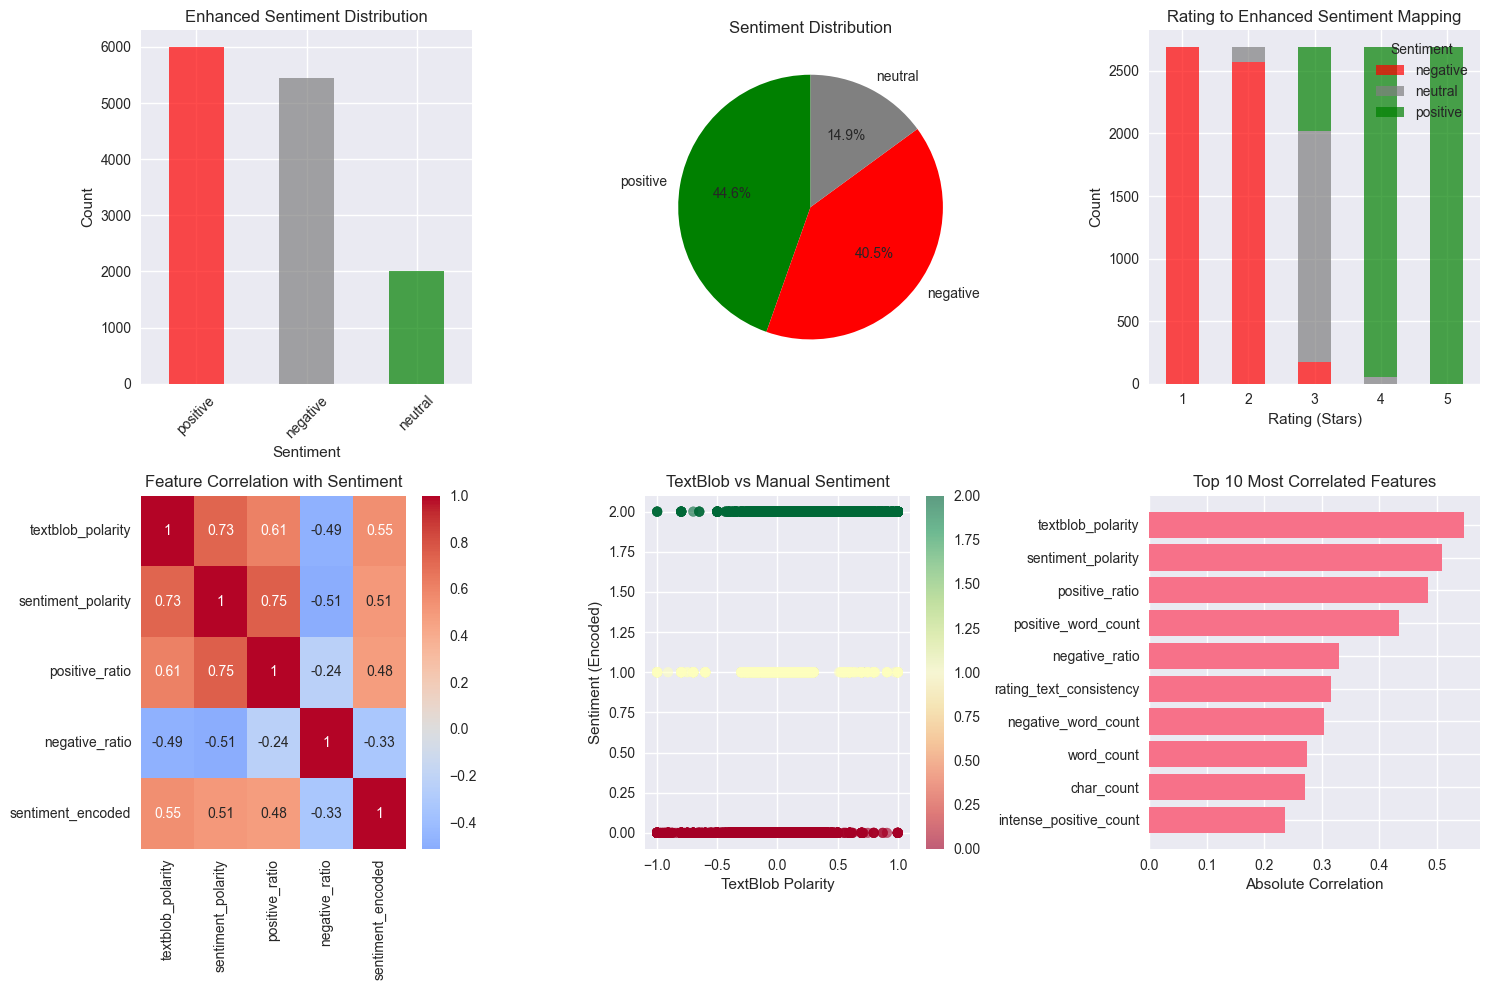


📊 Enhanced Feature Statistics:
Total combined features: 1625
Statistical features: 25
TF-IDF selected features: 1500
SVD features: 100

Statistical features summary:
         char_count    word_count  sentence_count  avg_word_length  \
count  13445.000000  13445.000000    13445.000000     13445.000000   
mean     137.428040     14.608851        2.409297         5.212752   
std      127.335884     12.831223        1.954987         0.866573   
min       11.000000      3.000000        1.000000         2.000000   
25%       44.000000      5.000000        1.000000         4.666667   
50%       88.000000     10.000000        2.000000         5.200000   
75%      188.000000     20.000000        3.000000         5.733333   
max      500.000000     86.000000       22.000000        10.250000   

       avg_sentence_length  exclamation_count  question_count  \
count         13445.000000       13445.000000    13445.000000   
mean              6.799661           0.160283        0.115433   
std    

In [7]:
# Enhanced Feature Extraction & Labeling with Advanced Techniques
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
import pandas as pd

def create_sentiment_labels_enhanced(rating, text=None):
    """Enhanced sentiment labeling with text analysis validation"""
    # Base sentiment from rating
    if rating <= 2:
        base_sentiment = 'negative'
    elif rating == 3:
        base_sentiment = 'neutral'
    else:
        base_sentiment = 'positive'
    
    # Optional: Validate with text analysis (if available)
    if text and pd.notna(text) and len(str(text).strip()) > 10:
        try:
            # Use TextBlob for sentiment validation
            blob = TextBlob(str(text))
            text_polarity = blob.sentiment.polarity
            
            # Adjust for edge cases where rating and text sentiment strongly disagree
            if rating == 3:  # Neutral ratings - check text sentiment
                if text_polarity > 0.3:
                    return 'positive'
                elif text_polarity < -0.3:
                    return 'negative'
            elif rating == 2 and text_polarity > 0.5:  # 2-star but very positive text
                return 'neutral'
            elif rating == 4 and text_polarity < -0.5:  # 4-star but very negative text
                return 'neutral'
        except:
            pass  # If text analysis fails, use base sentiment
    
    return base_sentiment

def create_advanced_text_features(df):
    """Create comprehensive text features for better classification"""
    
    print("🔧 Creating advanced text features...")
    
    # Ensure we have the processed text
    if 'content_processed' not in df.columns:
        print("⚠️ content_processed not found, using content column")
        df['content_processed'] = df['content'].fillna('')
    
    # 1. Basic statistical features
    df['char_count'] = df['content'].astype(str).str.len()
    df['word_count'] = df['content_processed'].str.split().str.len()
    df['sentence_count'] = df['content'].astype(str).str.count('[.!?]+') + 1
    df['avg_word_length'] = df['content_processed'].apply(
        lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
    )
    df['avg_sentence_length'] = df['word_count'] / df['sentence_count']
    
    # 2. Punctuation and formatting features
    df['exclamation_count'] = df['content'].astype(str).str.count('!')
    df['question_count'] = df['content'].astype(str).str.count('\?')
    df['period_count'] = df['content'].astype(str).str.count('\.')
    df['comma_count'] = df['content'].astype(str).str.count(',')
    df['uppercase_count'] = df['content'].astype(str).str.count('[A-Z]')
    df['uppercase_ratio'] = df['uppercase_count'] / (df['char_count'] + 1)
    
    # 3. Enhanced sentiment word features
    positive_words = [
        'amazing', 'awesome', 'excellent', 'fantastic', 'great', 'love', 'perfect', 'wonderful',
        'brilliant', 'outstanding', 'superb', 'terrific', 'marvelous', 'good', 'nice', 'best',
        'beautiful', 'incredible', 'spectacular', 'phenomenal', 'magnificent', 'fabulous',
        'exceptional', 'remarkable', 'impressive', 'stunning', 'flawless', 'ideal'
    ]
    
    negative_words = [
        'awful', 'terrible', 'horrible', 'bad', 'worst', 'hate', 'disgusting', 'annoying',
        'frustrating', 'disappointing', 'useless', 'pathetic', 'ridiculous', 'boring', 'poor',
        'sucks', 'waste', 'trash', 'garbage', 'stupid', 'dumb', 'ugly', 'broken', 'failed',
        'disaster', 'nightmare', 'catastrophe', 'abysmal', 'dreadful', 'appalling'
    ]
    
    neutral_words = [
        'okay', 'alright', 'decent', 'average', 'normal', 'standard', 'typical', 'regular',
        'acceptable', 'adequate', 'moderate', 'fair', 'reasonable', 'fine', 'so-so'
    ]
    
    # Count sentiment words
    df['positive_word_count'] = df['content_processed'].apply(
        lambda x: sum(1 for word in positive_words if word in x.lower().split())
    )
    
    df['negative_word_count'] = df['content_processed'].apply(
        lambda x: sum(1 for word in negative_words if word in x.lower().split())
    )
    
    df['neutral_word_count'] = df['content_processed'].apply(
        lambda x: sum(1 for word in neutral_words if word in x.lower().split())
    )
    
    # 4. Sentiment ratios and scores
    df['sentiment_word_total'] = df['positive_word_count'] + df['negative_word_count'] + df['neutral_word_count']
    df['positive_ratio'] = df['positive_word_count'] / (df['sentiment_word_total'] + 1)
    df['negative_ratio'] = df['negative_word_count'] / (df['sentiment_word_total'] + 1)
    df['neutral_ratio'] = df['neutral_word_count'] / (df['sentiment_word_total'] + 1)
    df['sentiment_polarity'] = (df['positive_word_count'] - df['negative_word_count']) / (df['word_count'] + 1)
    
    # 5. TextBlob sentiment analysis
    print("🔬 Computing TextBlob sentiment features...")
    def get_textblob_sentiment(text):
        try:
            blob = TextBlob(str(text))
            return blob.sentiment.polarity, blob.sentiment.subjectivity
        except:
            return 0.0, 0.0
    
    textblob_results = df['content'].apply(get_textblob_sentiment)
    df['textblob_polarity'] = [result[0] for result in textblob_results]
    df['textblob_subjectivity'] = [result[1] for result in textblob_results]
    
    # 6. Text complexity features
    df['unique_word_count'] = df['content_processed'].apply(
        lambda x: len(set(x.split())) if x else 0
    )
    df['lexical_diversity'] = df['unique_word_count'] / (df['word_count'] + 1)
    
    # 7. Readability features
    try:
        import textstat
        print("📊 Computing readability scores...")
        df['flesch_reading_ease'] = df['content'].apply(
            lambda x: textstat.flesch_reading_ease(str(x)) if pd.notna(x) and len(str(x)) > 10 else 50
        )
        df['flesch_kincaid_grade'] = df['content'].apply(
            lambda x: textstat.flesch_kincaid_grade(str(x)) if pd.notna(x) and len(str(x)) > 10 else 5
        )
        df['automated_readability_index'] = df['content'].apply(
            lambda x: textstat.automated_readability_index(str(x)) if pd.notna(x) and len(str(x)) > 10 else 5
        )
    except ImportError:
        print("⚠️ textstat not available, using default readability values")
        df['flesch_reading_ease'] = 50
        df['flesch_kincaid_grade'] = 5
        df['automated_readability_index'] = 5
    
    # 8. App-specific feature words
    spotify_positive = ['playlist', 'music', 'song', 'artist', 'album', 'quality', 'sound', 'premium']
    spotify_negative = ['ads', 'crash', 'bug', 'slow', 'freeze', 'error', 'subscription', 'expensive']
    
    df['spotify_positive_words'] = df['content_processed'].apply(
        lambda x: sum(1 for word in spotify_positive if word in x.lower().split())
    )
    
    df['spotify_negative_words'] = df['content_processed'].apply(
        lambda x: sum(1 for word in spotify_negative if word in x.lower().split())
    )
    
    # 9. Emotional intensity features
    intense_positive = ['love', 'amazing', 'fantastic', 'perfect', 'excellent', 'incredible']
    intense_negative = ['hate', 'terrible', 'awful', 'horrible', 'disgusting', 'worst']
    
    df['intense_positive_count'] = df['content_processed'].apply(
        lambda x: sum(1 for word in intense_positive if word in x.lower().split())
    )
    
    df['intense_negative_count'] = df['content_processed'].apply(
        lambda x: sum(1 for word in intense_negative if word in x.lower().split())
    )
    
    df['emotional_intensity'] = (df['intense_positive_count'] + df['intense_negative_count']) / (df['word_count'] + 1)
    
    # 10. Rating consistency features
    df['rating_text_consistency'] = df.apply(
        lambda row: 1 if (
            (row['score'] >= 4 and row['textblob_polarity'] > 0) or
            (row['score'] <= 2 and row['textblob_polarity'] < 0) or
            (row['score'] == 3 and abs(row['textblob_polarity']) < 0.1)
        ) else 0, axis=1
    )
    
    return df

def create_advanced_vectorization_features(df, target_col='sentiment'):
    """Create advanced vectorization features with multiple techniques"""
    
    print("🔧 Creating advanced vectorization features...")
    
    # Prepare text data
    text_data = df['content_processed'].fillna('')
    target_data = df[target_col]
    
    # 1. Enhanced TF-IDF with multiple n-gram ranges
    print("📊 Creating TF-IDF features...")
    
    # Unigrams and bigrams
    tfidf_1_2 = TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=3000,
        min_df=3,
        max_df=0.9,
        sublinear_tf=True,
        strip_accents='unicode'
    )
    tfidf_features_1_2 = tfidf_1_2.fit_transform(text_data)
    
    # Character n-grams (good for handling typos and variations)
    tfidf_char = TfidfVectorizer(
        analyzer='char',
        ngram_range=(2, 4),
        max_features=1000,
        min_df=3,
        max_df=0.9
    )
    tfidf_char_features = tfidf_char.fit_transform(text_data)
    
    # 2. Count vectorizer with binary features
    print("📊 Creating Count Vectorizer features...")
    count_vectorizer = CountVectorizer(
        ngram_range=(1, 2),
        max_features=2000,
        min_df=3,
        max_df=0.9,
        binary=True
    )
    count_features = count_vectorizer.fit_transform(text_data)
    
    # 3. Feature selection on TF-IDF features
    print("🎯 Selecting best features...")
    selector = SelectKBest(score_func=chi2, k=min(1500, tfidf_features_1_2.shape[1]))
    selected_features = selector.fit_transform(tfidf_features_1_2, target_data)
    
    # 4. Dimensionality reduction
    print("📉 Applying dimensionality reduction...")
    svd = TruncatedSVD(n_components=100, random_state=42)
    svd_features = svd.fit_transform(tfidf_features_1_2)
    
    # Create feature names
    feature_names = {
        'tfidf_1_2': [f'tfidf_{i}' for i in range(tfidf_features_1_2.shape[1])],
        'tfidf_char': [f'tfidf_char_{i}' for i in range(tfidf_char_features.shape[1])],
        'count': [f'count_{i}' for i in range(count_features.shape[1])],
        'selected': [f'selected_{i}' for i in range(selected_features.shape[1])],
        'svd': [f'svd_{i}' for i in range(svd_features.shape[1])]
    }
    
    return {
        'tfidf_1_2': tfidf_features_1_2,
        'tfidf_char': tfidf_char_features,
        'count': count_features,
        'selected': selected_features,
        'svd': svd_features,
        'vectorizers': {
            'tfidf_1_2': tfidf_1_2,
            'tfidf_char': tfidf_char,
            'count': count_vectorizer,
            'selector': selector,
            'svd': svd
        },
        'feature_names': feature_names
    }

def combine_features(df, vectorization_features, feature_columns=None):
    """Combine textual features with statistical features"""
    
    print("🔗 Combining all features...")
    
    # Default feature columns if not specified
    if feature_columns is None:
        feature_columns = [
            'char_count', 'word_count', 'sentence_count', 'avg_word_length', 'avg_sentence_length',
            'exclamation_count', 'question_count', 'uppercase_ratio',
            'positive_word_count', 'negative_word_count', 'neutral_word_count',
            'positive_ratio', 'negative_ratio', 'sentiment_polarity',
            'textblob_polarity', 'textblob_subjectivity',
            'lexical_diversity', 'flesch_reading_ease', 'flesch_kincaid_grade',
            'spotify_positive_words', 'spotify_negative_words',
            'intense_positive_count', 'intense_negative_count', 'emotional_intensity',
            'rating_text_consistency'
        ]
    
    # Filter existing columns
    available_columns = [col for col in feature_columns if col in df.columns]
    statistical_features = df[available_columns].values
    
    # Standardize statistical features
    scaler = StandardScaler()
    statistical_features_scaled = scaler.fit_transform(statistical_features)
    
    # Combine with best vectorization features (using selected features)
    from scipy.sparse import hstack, csr_matrix
    
    # Convert statistical features to sparse matrix
    statistical_sparse = csr_matrix(statistical_features_scaled)
    
    # Combine features
    combined_features = hstack([
        vectorization_features['selected'],  # Selected TF-IDF features
        statistical_sparse,  # Statistical features
        vectorization_features['svd']  # SVD features
    ])
    
    return combined_features, scaler, available_columns

# Apply enhanced sentiment labeling
print("🏷️ ENHANCED FEATURE EXTRACTION & LABELING")
print("=" * 60)

# Step 1: Enhanced sentiment labeling
print("\n1️⃣ Creating enhanced sentiment labels...")
df['sentiment'] = df.apply(
    lambda row: create_sentiment_labels_enhanced(row['score'], row.get('content', '')), 
    axis=1
)

# Step 2: Create advanced text features
print("\n2️⃣ Creating advanced text features...")
df = create_advanced_text_features(df)

# Step 3: Create vectorization features
print("\n3️⃣ Creating vectorization features...")
vectorization_features = create_advanced_vectorization_features(df, 'sentiment')

# Step 4: Combine all features
print("\n4️⃣ Combining features...")
combined_features, feature_scaler, feature_columns = combine_features(df, vectorization_features)

# Check enhanced label distribution
print("\n🏷️ Enhanced Sentiment Label Distribution:")
print("=" * 50)
sentiment_dist = df['sentiment'].value_counts()
print(sentiment_dist)
print(f"\nPercentages:")
print(sentiment_dist / len(df) * 100)

# Analyze label changes
original_labels = df['score'].apply(lambda x: 'negative' if x <= 2 else 'neutral' if x == 3 else 'positive')
label_changes = (df['sentiment'] != original_labels).sum()
print(f"\nLabel adjustments made: {label_changes} ({label_changes/len(df)*100:.1f}%)")

# Enhanced visualization
plt.figure(figsize=(15, 10))

# 1. Sentiment distribution (Bar chart)
plt.subplot(2, 3, 1)
colors = ['red', 'gray', 'green']
sentiment_dist.plot(kind='bar', color=colors, alpha=0.7)
plt.title('Enhanced Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)

# 2. Pie chart - FIX: Use current axes and ensure data exists
plt.subplot(2, 3, 2)
if len(sentiment_dist) > 0 and sentiment_dist.sum() > 0:
    # Ensure we have valid colors for each sentiment
    sentiment_colors = []
    for sentiment in sentiment_dist.index:
        if sentiment == 'negative':
            sentiment_colors.append('red')
        elif sentiment == 'neutral':
            sentiment_colors.append('gray')
        elif sentiment == 'positive':
            sentiment_colors.append('green')
        else:
            sentiment_colors.append('blue')  # fallback color
    
    plt.pie(sentiment_dist.values, 
             labels=sentiment_dist.index, 
             autopct='%1.1f%%', 
             colors=sentiment_colors,
             startangle=90)
    plt.title('Sentiment Distribution')
else:
    plt.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Sentiment Distribution (No Data)')

# 3. Rating vs Enhanced Sentiment mapping - FIX: Proper error handling
plt.subplot(2, 3, 3)
try:
    # Check if both columns exist and have data
    if 'score' in df.columns and 'sentiment' in df.columns and len(df) > 0:
        rating_sentiment = df.groupby(['score', 'sentiment']).size().unstack(fill_value=0)
        
        # Ensure we have data to plot
        if not rating_sentiment.empty and rating_sentiment.sum().sum() > 0:
            # Create color mapping for sentiments
            sentiment_cols = rating_sentiment.columns
            plot_colors = []
            for col in sentiment_cols:
                if col == 'negative':
                    plot_colors.append('red')
                elif col == 'neutral':
                    plot_colors.append('gray')
                elif col == 'positive':
                    plot_colors.append('green')
                else:
                    plot_colors.append('blue')  # fallback
            
            rating_sentiment.plot(kind='bar', 
                                stacked=True, 
                                color=plot_colors, 
                                alpha=0.7,
                                ax=plt.gca())
            plt.title('Rating to Enhanced Sentiment Mapping')
            plt.xlabel('Rating (Stars)')
            plt.ylabel('Count')
            plt.xticks(rotation=0)
            plt.legend(title='Sentiment')
        else:
            plt.text(0.5, 0.5, 'No rating-sentiment data', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Rating to Sentiment Mapping (No Data)')
    else:
        plt.text(0.5, 0.5, 'Missing required columns', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Rating to Sentiment Mapping (Error)')
except Exception as e:
    plt.text(0.5, 0.5, f'Error: {str(e)[:50]}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Rating to Sentiment Mapping (Error)')

# 4. Feature correlation with sentiment - FIX: Better error handling
plt.subplot(2, 3, 4)
try:
    # Encode sentiment for correlation
    from sklearn.preprocessing import LabelEncoder
    le_temp = LabelEncoder()
    
    if 'sentiment' in df.columns and len(df) > 0:
        sentiment_encoded = le_temp.fit_transform(df['sentiment'])
        
        correlation_features = ['textblob_polarity', 'sentiment_polarity', 'positive_ratio', 'negative_ratio']
        available_corr_features = [f for f in correlation_features if f in df.columns]
        
        if len(available_corr_features) > 0:
            corr_data = df[available_corr_features].copy()
            corr_data['sentiment_encoded'] = sentiment_encoded
            correlation_matrix = corr_data.corr()
            
            import seaborn as sns
            sns.heatmap(correlation_matrix, 
                       annot=True, 
                       cmap='coolwarm', 
                       center=0,
                       ax=plt.gca())
            plt.title('Feature Correlation with Sentiment')
        else:
            plt.text(0.5, 0.5, 'No correlation features available', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Feature Correlation (No Features)')
    else:
        plt.text(0.5, 0.5, 'No sentiment data available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Feature Correlation (No Data)')
except Exception as e:
    plt.text(0.5, 0.5, f'Correlation Error: {str(e)[:30]}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Correlation (Error)')

# 5. TextBlob vs Manual sentiment analysis - FIX: Data validation
plt.subplot(2, 3, 5)
try:
    if 'textblob_polarity' in df.columns and 'sentiment' in df.columns and len(df) > 0:
        # Re-encode sentiment for scatter plot
        sentiment_encoded = le_temp.fit_transform(df['sentiment'])
        
        # Filter out any NaN values
        mask = ~(df['textblob_polarity'].isna() | pd.isna(sentiment_encoded))
        if mask.sum() > 0:
            scatter = plt.scatter(df.loc[mask, 'textblob_polarity'], 
                                sentiment_encoded[mask], 
                                alpha=0.6, 
                                c=sentiment_encoded[mask], 
                                cmap='RdYlGn')
            plt.xlabel('TextBlob Polarity')
            plt.ylabel('Sentiment (Encoded)')
            plt.title('TextBlob vs Manual Sentiment')
            plt.colorbar(scatter)
        else:
            plt.text(0.5, 0.5, 'No valid polarity data', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('TextBlob vs Manual (No Valid Data)')
    else:
        plt.text(0.5, 0.5, 'Missing polarity features', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('TextBlob vs Manual (Missing Features)')
except Exception as e:
    plt.text(0.5, 0.5, f'Polarity Error: {str(e)[:30]}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('TextBlob vs Manual (Error)')

# 6. Feature importance preview - FIX: Data validation
plt.subplot(2, 3, 6)
try:
    if len(feature_columns) > 0 and 'sentiment' in df.columns and len(df) > 0:
        # Check which features actually exist
        existing_features = [col for col in feature_columns if col in df.columns]
        
        if len(existing_features) > 0:
            # Re-encode sentiment
            sentiment_encoded = le_temp.fit_transform(df['sentiment'])
            
            # Calculate correlation for existing features
            feature_data = df[existing_features].select_dtypes(include=[np.number])  # Only numeric features
            
            if len(feature_data.columns) > 0:
                # Handle NaN values
                feature_data_clean = feature_data.fillna(0)
                
                # Calculate correlations
                correlations = []
                for col in feature_data_clean.columns:
                    try:
                        corr = np.corrcoef(feature_data_clean[col], sentiment_encoded)[0, 1]
                        if not np.isnan(corr):
                            correlations.append((col, abs(corr)))
                    except:
                        continue
                
                if len(correlations) > 0:
                    # Sort and get top features
                    top_features = sorted(correlations, key=lambda x: x[1], reverse=True)[:10]
                    
                    if len(top_features) > 0:
                        features, importance = zip(*top_features)
                        y_pos = range(len(features))
                        plt.barh(y_pos, importance)
                        plt.yticks(y_pos, features)
                        plt.xlabel('Absolute Correlation')
                        plt.title(f'Top {len(features)} Most Correlated Features')
                        plt.gca().invert_yaxis()
                    else:
                        plt.text(0.5, 0.5, 'No valid correlations', ha='center', va='center', transform=plt.gca().transAxes)
                        plt.title('Feature Importance (No Correlations)')
                else:
                    plt.text(0.5, 0.5, 'Could not calculate correlations', ha='center', va='center', transform=plt.gca().transAxes)
                    plt.title('Feature Importance (Calculation Error)')
            else:
                plt.text(0.5, 0.5, 'No numeric features found', ha='center', va='center', transform=plt.gca().transAxes)
                plt.title('Feature Importance (No Numeric Features)')
        else:
            plt.text(0.5, 0.5, 'No features available', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Feature Importance (No Features)')
    else:
        plt.text(0.5, 0.5, 'No feature data available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Feature Importance (No Data)')
except Exception as e:
    plt.text(0.5, 0.5, f'Feature Error: {str(e)[:30]}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Importance (Error)')

plt.tight_layout()
plt.show()

# Feature statistics
print("\n📊 Enhanced Feature Statistics:")
print("=" * 60)
print(f"Total combined features: {combined_features.shape[1]}")
print(f"Statistical features: {len(feature_columns)}")
print(f"TF-IDF selected features: {vectorization_features['selected'].shape[1]}")
print(f"SVD features: {vectorization_features['svd'].shape[1]}")

# Display sample of statistical features
if len(feature_columns) > 0:
    print(f"\nStatistical features summary:")
    print(df[feature_columns].describe())

# Prepare final data for modeling
print("\n🔧 Preparing enhanced data for modeling...")

# Features and target
X_enhanced = combined_features
y_enhanced = df['sentiment']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_enhanced)

print(f"\n✅ Enhanced data prepared:")
print(f"   - Features (X): {X_enhanced.shape[0]} samples, {X_enhanced.shape[1]} features")
print(f"   - Labels (y): {len(y_enhanced)} sentiment labels")
print(f"   - Classes: {label_encoder.classes_}")
print(f"   - Encoded mapping: {dict(enumerate(label_encoder.classes_))}")

# Final class distribution
unique, counts = np.unique(y_encoded, return_counts=True)
print(f"\n📊 Final class distribution:")
for i, (label, count) in enumerate(zip(label_encoder.classes_, counts)):
    print(f"   {i}: {label} = {count} samples ({count/len(y_enhanced)*100:.1f}%)")

# Store enhanced data for experiments
X = X_enhanced  # Use enhanced features for modeling
y = y_encoded   # Use enhanced labels
print(f"\n🎯 Enhanced features ready for experiments!")
print(f"Feature density: {X.nnz / (X.shape[0] * X.shape[1]):.4f}")

📊 Text Analysis by Sentiment:
Text length statistics by sentiment:
                 mean  median         std
sentiment                                
negative   170.654228   124.0  139.052978
neutral    170.318408   129.0  137.532106
positive    96.250375    61.0   97.065885


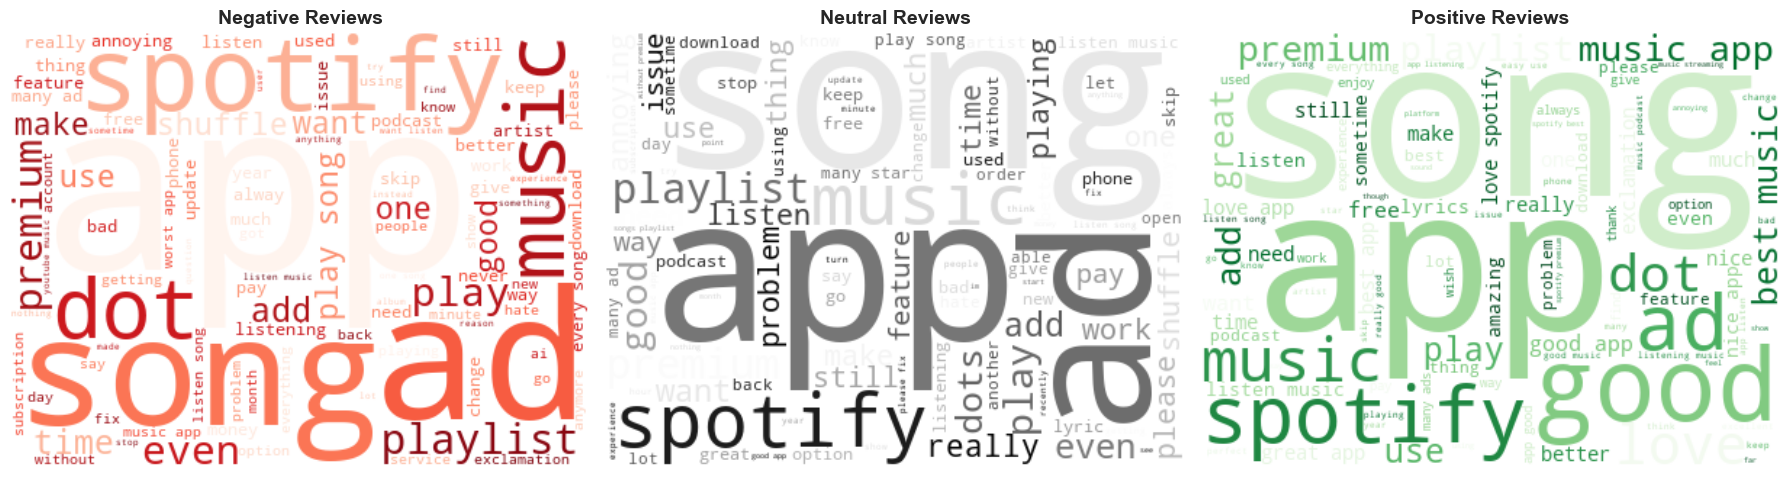

In [8]:
# Text analysis and word clouds
print("📊 Text Analysis by Sentiment:")
print("=" * 50)

# Calculate average text length by sentiment
text_stats = df.groupby('sentiment')['content_length'].agg(['mean', 'median', 'std'])
print("Text length statistics by sentiment:")
print(text_stats)

# Create word clouds for each sentiment
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sentiments = ['negative', 'neutral', 'positive']
colors = ['Reds', 'Greys', 'Greens']

for i, sentiment in enumerate(sentiments):
    text_data = ' '.join(df[df['sentiment'] == sentiment]['content_processed'])
    
    if len(text_data) > 0:
        wordcloud = WordCloud(width=400, height=300, 
                            background_color='white',
                            colormap=colors[i],
                            max_words=100).generate(text_data)
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{sentiment.capitalize()} Reviews', fontsize=14, fontweight='bold')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

## 🤖 4. Machine Learning Models - 3 Experiments

### Experiment 1: SVM + TF-IDF (80/20 split)
### Experiment 2: Random Forest + Enhanced Features (80/20 split)  
### Experiment 3: Deep Learning LSTM + Advanced Architecture (80/20 split)
### Experiment 4: Advanced Ensemble Methods (80/20 split)

In [11]:
# Store results for comparison
experiment_results = []

def evaluate_model(y_true, y_pred, model_name, split_info):
    """Evaluate model performance and store results"""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    result = {
        'model': model_name,
        'split': split_info,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    print(f"\n📊 {model_name} Results:")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return result

# PERBAIKAN: Gunakan processed text data untuk eksperimen
def prepare_text_data_for_experiments(df):
    """Prepare processed text data for experiments"""
    # Gunakan processed text data, bukan sparse matrix
    text_data = df['content_processed'].fillna('')
    labels = df['sentiment']
    
    # Encode labels
    label_encoder_exp = LabelEncoder()
    encoded_labels = label_encoder_exp.fit_transform(labels)
    
    return text_data.values, encoded_labels, label_encoder_exp

# Prepare data untuk eksperimen
print("🔧 Preparing data for experiments...")
X_text, y_labels, label_encoder_exp = prepare_text_data_for_experiments(df)
print(f"Text data shape: {X_text.shape}")
print(f"Labels shape: {y_labels.shape}")
print(f"Classes: {label_encoder_exp.classes_}")

🔧 Preparing data for experiments...
Text data shape: (13445,)
Labels shape: (13445,)
Classes: ['negative' 'neutral' 'positive']


### 🧪 Experiment 1: SVM + TF-IDF (80/20 split)

🧪 EXPERIMENT 1: SVM + TF-IDF (80/20 split)
Training set: 10756 samples
Testing set: 2689 samples

🔧 TF-IDF Feature Extraction...
TF-IDF shape: (10756, 8000)
Feature density: 0.0018

🎯 Training SVM with Optimized Grid Search...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best SVM parameters: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 0.8331

📈 Training Accuracy: 0.9943 (99.43%)

📊 SVM + TF-IDF Results:
Accuracy: 0.8587 (85.87%)
Precision: 0.8597
Recall: 0.8587
F1-Score: 0.8546


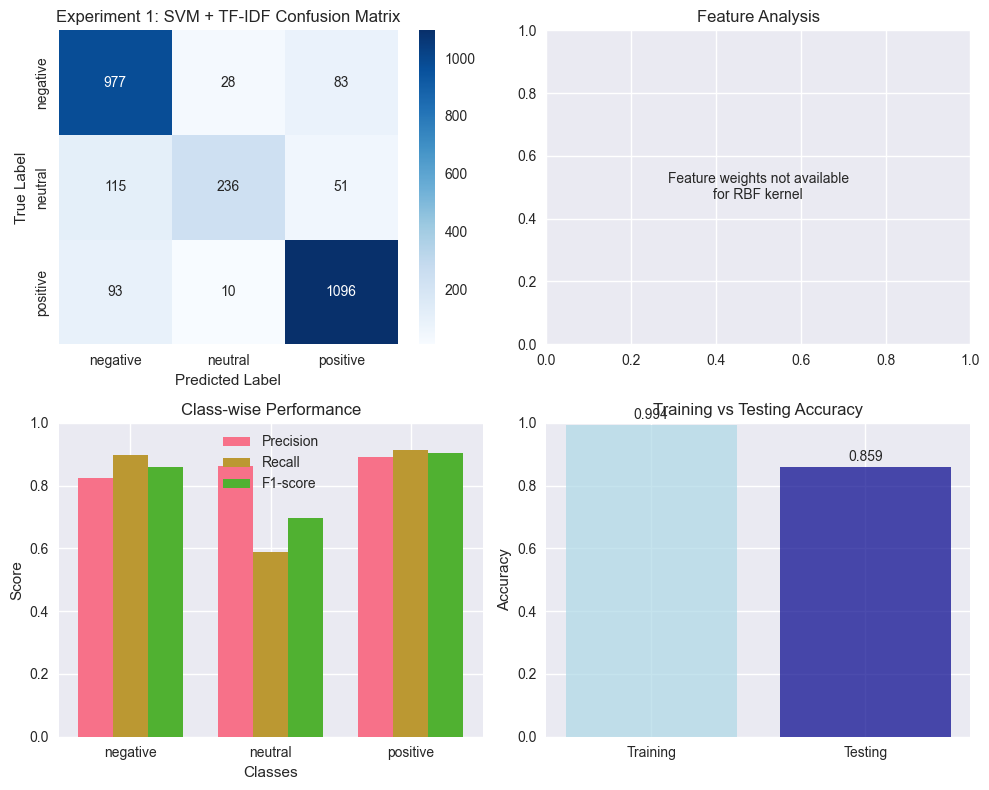


📋 Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.90      0.86      1088
     neutral       0.86      0.59      0.70       402
    positive       0.89      0.91      0.90      1199

    accuracy                           0.86      2689
   macro avg       0.86      0.80      0.82      2689
weighted avg       0.86      0.86      0.85      2689



In [12]:
print("🧪 EXPERIMENT 1: SVM + TF-IDF (80/20 split)")
print("=" * 60)

# Data split 80/20 - GUNAKAN TEXT DATA YANG BENAR
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_text, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

print(f"Training set: {len(X_train1)} samples")
print(f"Testing set: {len(X_test1)} samples")

# TF-IDF Vectorization - OPTIMIZED PARAMETERS
print("\n🔧 TF-IDF Feature Extraction...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=8000,  # Increased from 5000
    ngram_range=(1, 3),  # Added trigrams
    min_df=2,
    max_df=0.90,  # Slightly more restrictive
    sublinear_tf=True,  # Better for large datasets
    stop_words='english',  # Remove English stopwords
    lowercase=True,
    strip_accents='unicode'
)

X_train1_tfidf = tfidf_vectorizer.fit_transform(X_train1)
X_test1_tfidf = tfidf_vectorizer.transform(X_test1)

print(f"TF-IDF shape: {X_train1_tfidf.shape}")
print(f"Feature density: {X_train1_tfidf.nnz / (X_train1_tfidf.shape[0] * X_train1_tfidf.shape[1]):.4f}")

# SVM Model with OPTIMIZED Grid Search
print("\n🎯 Training SVM with Optimized Grid Search...")
svm_params = {
    'C': [0.5, 1, 5, 10],  # Expanded range
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.001, 0.01]  # Added specific values
}

svm_model = SVC(random_state=42, class_weight='balanced')  # Added class_weight
svm_grid = GridSearchCV(
    svm_model, 
    svm_params, 
    cv=5,  # Increased CV folds
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)
svm_grid.fit(X_train1_tfidf, y_train1)

print(f"Best SVM parameters: {svm_grid.best_params_}")
print(f"Best CV score: {svm_grid.best_score_:.4f}")

# Predictions and evaluation
y_train1_pred = svm_grid.predict(X_train1_tfidf)
y_test1_pred = svm_grid.predict(X_test1_tfidf)

# Training accuracy
train_acc1 = accuracy_score(y_train1, y_train1_pred)
print(f"\n📈 Training Accuracy: {train_acc1:.4f} ({train_acc1*100:.2f}%)")

# Testing accuracy
result1 = evaluate_model(y_test1, y_test1_pred, "SVM + TF-IDF", "80/20")
result1['train_accuracy'] = train_acc1
experiment_results.append(result1)

# Confusion Matrix
cm1 = confusion_matrix(y_test1, y_test1_pred)
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder_exp.classes_, 
            yticklabels=label_encoder_exp.classes_)
plt.title('Experiment 1: SVM + TF-IDF Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Feature Analysis
plt.subplot(2, 2, 2)
feature_names = tfidf_vectorizer.get_feature_names_out()
if hasattr(svm_grid.best_estimator_, 'coef_'):
    # For linear kernel, show feature importance
    coef = svm_grid.best_estimator_.coef_[0]
    top_positive_idx = np.argsort(coef)[-10:]
    top_negative_idx = np.argsort(coef)[:10]
    
    plt.barh(range(10), coef[top_negative_idx], color='red', alpha=0.7, label='Negative')
    plt.barh(range(10, 20), coef[top_positive_idx], color='green', alpha=0.7, label='Positive')
    plt.yticks(range(20), list(feature_names[top_negative_idx]) + list(feature_names[top_positive_idx]))
    plt.title('Top Features (SVM Linear Kernel)')
    plt.xlabel('Coefficient Value')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'Feature weights not available\nfor RBF kernel', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Analysis')

# Class-wise performance
plt.subplot(2, 2, 3)
report = classification_report(y_test1, y_test1_pred, target_names=label_encoder_exp.classes_, output_dict=True)
classes = label_encoder_exp.classes_
metrics = ['precision', 'recall', 'f1-score']
x = np.arange(len(classes))
width = 0.25

for i, metric in enumerate(metrics):
    values = [report[cls][metric] for cls in classes]
    plt.bar(x + i*width, values, width, label=metric.capitalize())

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Class-wise Performance')
plt.xticks(x + width, classes)
plt.legend()
plt.ylim(0, 1)

# Accuracy trend
plt.subplot(2, 2, 4)
plt.bar(['Training', 'Testing'], [train_acc1, result1['accuracy']], 
        color=['lightblue', 'darkblue'], alpha=0.7)
plt.title('Training vs Testing Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate([train_acc1, result1['accuracy']]):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Classification Report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_test1, y_test1_pred, target_names=label_encoder_exp.classes_))

### 🧪 Experiment 2: Random Forest + Enhanced Features (80/20 split)

🧪 EXPERIMENT 2: Random Forest + Enhanced Features (80/20 split)
Training set: 10756 samples
Testing set: 2689 samples

🔧 Creating Enhanced Feature Set...
Available statistical features: 13
Combined features shape: (10756, 6013)

🌲 Training Random Forest with Optimized Parameters...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best RF parameters: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.8330

📈 Training Accuracy: 0.9997 (99.97%)

📊 Random Forest + Enhanced Features Results:
Accuracy: 0.8698 (86.98%)
Precision: 0.8794
Recall: 0.8698
F1-Score: 0.8650


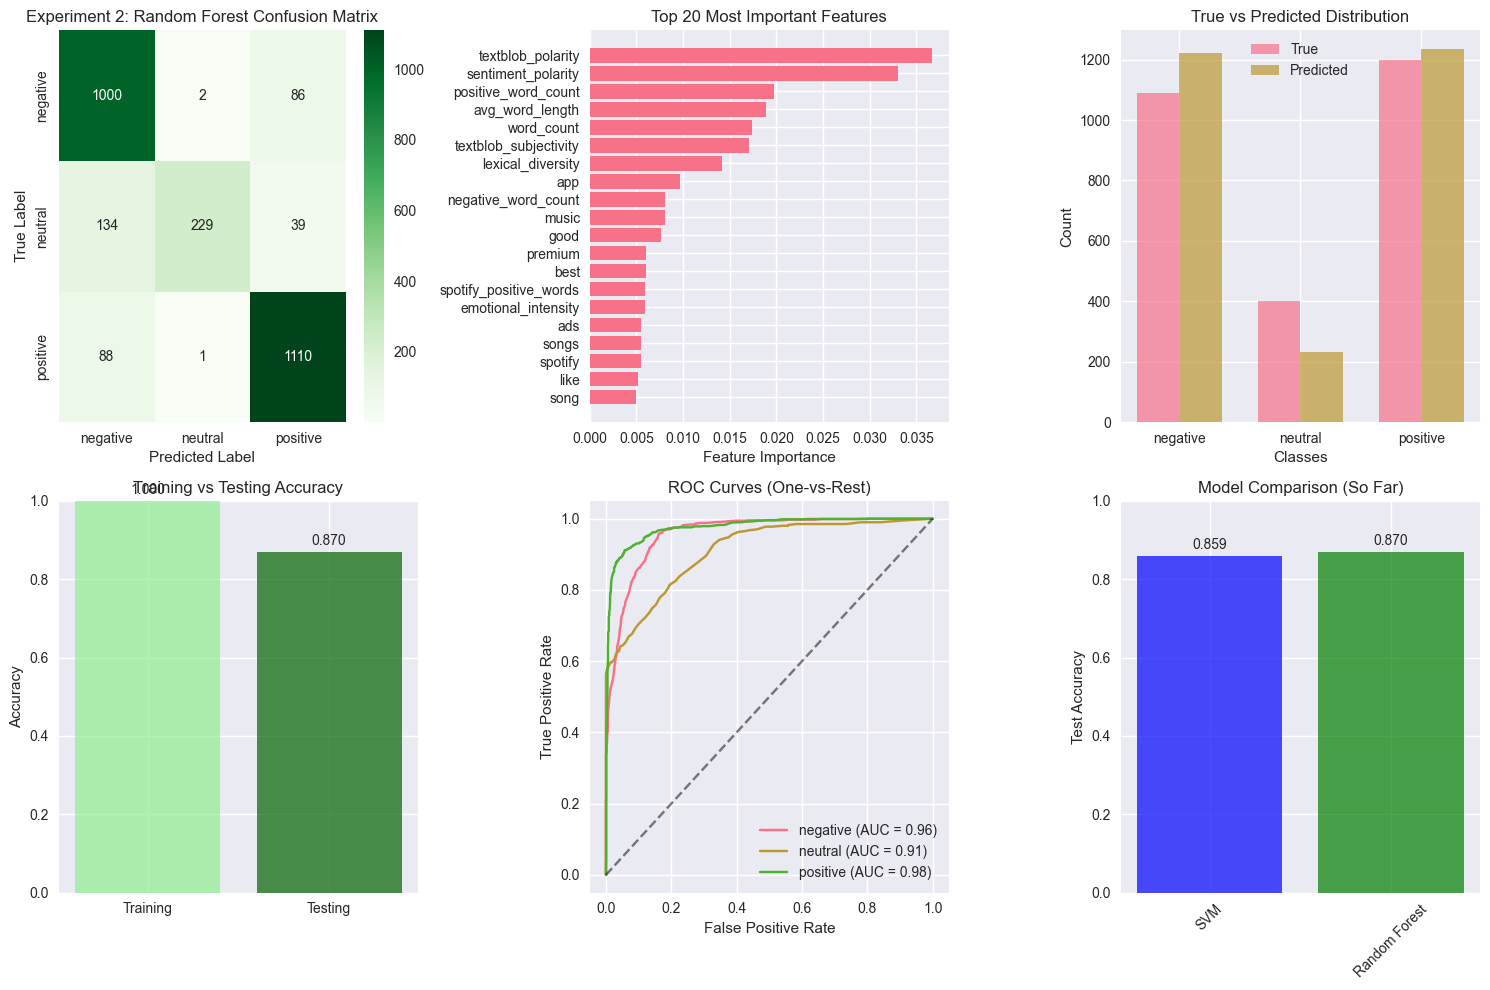


📋 Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.92      0.87      1088
     neutral       0.99      0.57      0.72       402
    positive       0.90      0.93      0.91      1199

    accuracy                           0.87      2689
   macro avg       0.90      0.80      0.83      2689
weighted avg       0.88      0.87      0.86      2689



In [14]:
print("🧪 EXPERIMENT 2: Random Forest + Enhanced Features (80/20 split)")
print("=" * 60)

# Use same data split as experiment 1 for fair comparison
print(f"Training set: {len(X_train1)} samples")
print(f"Testing set: {len(X_test1)} samples")

# ENHANCED: Combine TF-IDF with statistical features
print("\n🔧 Creating Enhanced Feature Set...")

# 1. TF-IDF features
tfidf_vectorizer_rf = TfidfVectorizer(
    max_features=6000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True,
    stop_words='english'
)

X_train2_tfidf = tfidf_vectorizer_rf.fit_transform(X_train1)
X_test2_tfidf = tfidf_vectorizer_rf.transform(X_test1)

# 2. Statistical features from our enhanced preprocessing
statistical_features = [
    'word_count', 'avg_word_length', 'exclamation_count', 'question_count',
    'positive_word_count', 'negative_word_count', 'sentiment_polarity',
    'textblob_polarity', 'textblob_subjectivity', 'lexical_diversity',
    'spotify_positive_words', 'spotify_negative_words', 'emotional_intensity'
]

# Get indices for train/test split to match statistical features
train_indices = []
test_indices = []
for i, text in enumerate(X_text):
    if text in X_train1:
        # Find the first occurrence
        train_idx = np.where(X_text == text)[0][0]
        train_indices.append(train_idx)
    else:
        test_idx = np.where(X_text == text)[0][0]
        test_indices.append(test_idx)

# Create proper mapping
train_mapping = {text: i for i, text in enumerate(X_train1)}
test_mapping = {text: i for i, text in enumerate(X_test1)}

# Extract statistical features
available_stat_features = [col for col in statistical_features if col in df.columns]
print(f"Available statistical features: {len(available_stat_features)}")

if len(available_stat_features) > 0:
    # Create a mapping from text to dataframe index
    text_to_df_idx = {text: i for i, text in enumerate(df['content_processed'].fillna(''))}
    
    # Get train and test statistical features
    train_stat_features = []
    test_stat_features = []
    
    for text in X_train1:
        if text in text_to_df_idx:
            df_idx = text_to_df_idx[text]
            features = df.iloc[df_idx][available_stat_features].values
            train_stat_features.append(features)
        else:
            # Default values if not found
            train_stat_features.append(np.zeros(len(available_stat_features)))
    
    for text in X_test1:
        if text in text_to_df_idx:
            df_idx = text_to_df_idx[text]
            features = df.iloc[df_idx][available_stat_features].values
            test_stat_features.append(features)
        else:
            # Default values if not found
            test_stat_features.append(np.zeros(len(available_stat_features)))
    
    train_stat_features = np.array(train_stat_features)
    test_stat_features = np.array(test_stat_features)
    
    # Standardize statistical features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    train_stat_features = scaler.fit_transform(train_stat_features)
    test_stat_features = scaler.transform(test_stat_features)
    
    # Combine TF-IDF and statistical features
    from scipy.sparse import hstack, csr_matrix
    train_stat_sparse = csr_matrix(train_stat_features)
    test_stat_sparse = csr_matrix(test_stat_features)
    
    X_train2_combined = hstack([X_train2_tfidf, train_stat_sparse])
    X_test2_combined = hstack([X_test2_tfidf, test_stat_sparse])
    
    print(f"Combined features shape: {X_train2_combined.shape}")
else:
    # Fallback to TF-IDF only
    X_train2_combined = X_train2_tfidf
    X_test2_combined = X_test2_tfidf
    print("Using TF-IDF features only")

# Random Forest Model with OPTIMIZED parameters
print("\n🌲 Training Random Forest with Optimized Parameters...")
rf_params = {
    'n_estimators': [200, 300],  # More trees
    'max_depth': [15, 20, None],  # Deeper trees
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],  # Different feature selection strategies
    'class_weight': ['balanced']  # Handle class imbalance
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(
    rf_model, 
    rf_params, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)
rf_grid.fit(X_train2_combined, y_train1)

print(f"Best RF parameters: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_:.4f}")

# Predictions and evaluation
y_train2_pred = rf_grid.predict(X_train2_combined)
y_test2_pred = rf_grid.predict(X_test2_combined)

# Training accuracy
train_acc2 = accuracy_score(y_train1, y_train2_pred)
print(f"\n📈 Training Accuracy: {train_acc2:.4f} ({train_acc2*100:.2f}%)")

# Testing accuracy
result2 = evaluate_model(y_test1, y_test2_pred, "Random Forest + Enhanced Features", "80/20")
result2['train_accuracy'] = train_acc2
experiment_results.append(result2)

# Enhanced Visualization
plt.figure(figsize=(15, 10))

# Confusion Matrix
plt.subplot(2, 3, 1)
cm2 = confusion_matrix(y_test1, y_test2_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', 
            xticklabels=label_encoder_exp.classes_, 
            yticklabels=label_encoder_exp.classes_)
plt.title('Experiment 2: Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Feature Importance (Top 20)
plt.subplot(2, 3, 2)
feature_importance = rf_grid.best_estimator_.feature_importances_
tfidf_feature_names = list(tfidf_vectorizer_rf.get_feature_names_out())
all_feature_names = tfidf_feature_names + available_stat_features

top_features_idx = np.argsort(feature_importance)[-20:]
plt.barh(range(20), feature_importance[top_features_idx])
plt.yticks(range(20), [all_feature_names[i] if i < len(all_feature_names) else f'feature_{i}' 
                       for i in top_features_idx])
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')

# Class distribution in predictions
plt.subplot(2, 3, 3)
pred_dist = pd.Series(y_test2_pred).value_counts().sort_index()
true_dist = pd.Series(y_test1).value_counts().sort_index()

x = np.arange(len(label_encoder_exp.classes_))
width = 0.35

plt.bar(x - width/2, true_dist.values, width, label='True', alpha=0.7)
plt.bar(x + width/2, pred_dist.values, width, label='Predicted', alpha=0.7)

plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('True vs Predicted Distribution')
plt.xticks(x, label_encoder_exp.classes_)
plt.legend()

# Learning curve simulation
plt.subplot(2, 3, 4)
accuracies = [train_acc2, result2['accuracy']]
plt.bar(['Training', 'Testing'], accuracies, color=['lightgreen', 'darkgreen'], alpha=0.7)
plt.title('Training vs Testing Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# ROC Curve (if possible)
plt.subplot(2, 3, 5)
try:
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    
    # Binarize labels for multiclass ROC
    y_test_bin = label_binarize(y_test1, classes=[0, 1, 2])
    y_pred_proba = rf_grid.predict_proba(X_test2_combined)
    
    for i, class_name in enumerate(label_encoder_exp.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.legend()
except:
    plt.text(0.5, 0.5, 'ROC curve not available', ha='center', va='center')
    plt.title('ROC Analysis')

# Model comparison so far
plt.subplot(2, 3, 6)
if len(experiment_results) >= 2:
    models = [r['model'].split(' + ')[0] for r in experiment_results]
    accuracies = [r['accuracy'] for r in experiment_results]
    
    plt.bar(models, accuracies, color=['blue', 'green'], alpha=0.7)
    plt.title('Model Comparison (So Far)')
    plt.ylabel('Test Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Classification Report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_test1, y_test2_pred, target_names=label_encoder_exp.classes_))

### 🧪 Experiment 3: Deep Learning LSTM + Advanced Architecture (80/20 split)

🧪 EXPERIMENT 3: Deep Learning LSTM + Advanced Architecture (70/30 split)
Training set: 9411 samples
Testing set: 4034 samples

🔧 Enhanced Tokenization for Deep Learning...
Sequence shape: (9411, 150)
Labels shape: (9411, 3)
Vocabulary size: 8755
Average sequence length: 14.4

🧠 Building Enhanced LSTM Architecture...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

🏋️ Training Enhanced LSTM model...
Class weights: {0: np.float64(0.8237920168067226), 1: np.float64(2.2295664534470503), 2: np.float64(0.7476167778836987)}
Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.3931 - loss: 1.5979 - precision: 0.3968 - recall: 0.3073
Epoch 1: val_accuracy improved from None to 0.44596, saving model to best_model.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.4383 - loss: 1.3919 - precision: 0.4560 - recall: 0.3397 - val_accuracy: 0.4460 - val_loss: 1.1234 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.5447 - loss: 1.0579 - precision: 0.6057 - recall: 0.4167
Epoch 2: val_accuracy improved from 0.44596 to 0.46529, saving model to best_model.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 145s 981ms/step - accuracy: 0.5601 - loss: 1.0299 - precision: 0.6333 - recall: 0.4302 - val_accuracy: 0.4653 - val_loss: 1.0504 - val_precision: 0.9658 - val_recall: 0.0560 - learning_rate: 0.0010
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6329 - loss: 0.9249 - precision: 0.7111 - recall: 0.4963
Epoch 3: val_accuracy improved from 0.46529 to 0.58924, saving model to best_model.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.6382 - loss: 0.9029 - precision: 0.7164 - recall: 0.5165 - val_accuracy: 0.5892 - val_loss: 0.9064 - val_precision: 0.9484 - val_recall: 0.2826 - learning_rate: 0.0010
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6887 - loss: 0.8228 - precision: 0.7697 - recall: 0.5942
Epoch 4: val_accuracy improved from 0.58924 to 0.72781, saving model to best_model.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.7002 - loss: 0.8067 - precision: 0.7742 - recall: 0.6124 - val_accuracy: 0.7278 - val_loss: 0.7521 - val_precision: 0.8471 - val_recall: 0.6083 - learning_rate: 0.0010
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7785 - loss: 0.6867 - precision: 0.8312 - recall: 0.7093
Epoch 5: val_accuracy improved from 0.72781 to 0.74368, saving model to best_model.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.7723 - loss: 0.6910 - precision: 0.8190 - recall: 0.7099 - val_accuracy: 0.7437 - val_loss: 0.7225 - val_precision: 0.7918 - val_recall: 0.6956 - learning_rate: 0.0010
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8108 - loss: 0.5797 - precision: 0.8527 - recall: 0.7638
Epoch 6: val_accuracy improved from 0.74368 to 0.75037, saving model to best_model.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.8130 - loss: 0.5871 - precision: 0.8516 - recall: 0.7719 - val_accuracy: 0.7504 - val_loss: 0.7430 - val_precision: 0.7911 - val_recall: 0.7211 - learning_rate: 0.0010
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8463 - loss: 0.5229 - precision: 0.8788 - recall: 0.8123
Epoch 7: val_accuracy improved from 0.75037 to 0.76078, saving model to best_model.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.8432 - loss: 0.5342 - precision: 0.8711 - recall: 0.8102 - val_accuracy: 0.7608 - val_loss: 0.7729 - val_precision: 0.7838 - val_recall: 0.7253 - learning_rate: 0.0010
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8731 - loss: 0.4548 - precision: 0.8976 - recall: 0.8468
Epoch 8: val_accuracy did not improve from 0.76078
148/148 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8601 - loss: 0.4917 - precision: 0.8843 - recall: 0.8355 - val_accuracy: 0.7263 - val_loss: 0.8615 - val_precision: 0.7478 - val_recall: 0.6968 - learning_rate: 0.0010
Epoch 9/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8768 - loss: 0.4423 - precision: 0.9006 - recall: 0.8496
Epoch 9: val_accuracy did not improve from 0.76078
148/148 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.8775 - loss: 0.4447 - precision: 0.9005 - recall: 0.8534 - val_accuracy: 0.7605 - val_loss: 0.8107 - val_precision: 0.7785 - val_recall: 0.7414 - lear

148/148 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9013 - loss: 0.3741 - precision: 0.9204 - recall: 0.8828 - val_accuracy: 0.7789 - val_loss: 0.7905 - val_precision: 0.7939 - val_recall: 0.7603 - learning_rate: 5.0000e-04
Epoch 12/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9235 - loss: 0.3208 - precision: 0.9384 - recall: 0.9090
Epoch 12: val_accuracy did not improve from 0.77888
148/148 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9192 - loss: 0.3240 - precision: 0.9336 - recall: 0.9051 - val_accuracy: 0.7573 - val_loss: 0.8810 - val_precision: 0.7741 - val_recall: 0.7449 - learning_rate: 5.0000e-04
Epoch 13/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9249 - loss: 0.2991 - precision: 0.9374 - recall: 0.9134
Epoch 13: val_accuracy did not improve from 0.77888
148/148 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9272 - loss: 0.3007 - precision: 0.9393 - recall: 0.9149 - val_accuracy: 0.7774 - val_loss: 0.8529 - val_precision: 0.7919 - val_recall: 0

148/148 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9384 - loss: 0.2630 - precision: 0.9491 - recall: 0.9288 - val_accuracy: 0.7960 - val_loss: 0.8297 - val_precision: 0.8072 - val_recall: 0.7833 - learning_rate: 2.5000e-04
Epoch 16/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9490 - loss: 0.2470 - precision: 0.9576 - recall: 0.9407
Epoch 16: val_accuracy did not improve from 0.79598
148/148 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.9445 - loss: 0.2502 - precision: 0.9538 - recall: 0.9355 - val_accuracy: 0.7893 - val_loss: 0.8573 - val_precision: 0.7984 - val_recall: 0.7766 - learning_rate: 2.5000e-04
Epoch 17/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9512 - loss: 0.2328 - precision: 0.9574 - recall: 0.9418
Epoch 17: val_accuracy improved from 0.79598 to 0.80764, saving model to best_model.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.9495 - loss: 0.2387 - precision: 0.9556 - recall: 0.9399 - val_accuracy: 0.8076 - val_loss: 0.8448 - val_precision: 0.8158 - val_recall: 0.7980 - learning_rate: 2.5000e-04
Epoch 18/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9504 - loss: 0.2232 - precision: 0.9588 - recall: 0.9425
Epoch 18: val_accuracy did not improve from 0.80764
148/148 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.9480 - loss: 0.2279 - precision: 0.9578 - recall: 0.9394 - val_accuracy: 0.7975 - val_loss: 0.8839 - val_precision: 0.8067 - val_recall: 0.7861 - learning_rate: 2.5000e-04
Epoch 19/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9489 - loss: 0.2342 - precision: 0.9547 - recall: 0.9414
Epoch 19: val_accuracy did not improve from 0.80764
148/148 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.9464 - loss: 0.2361 - precision: 0.9526 - recall: 0.9383 - val_accuracy: 0.7910 - val_loss: 0.8956 - val_precision: 0.8064 - val_recall: 0

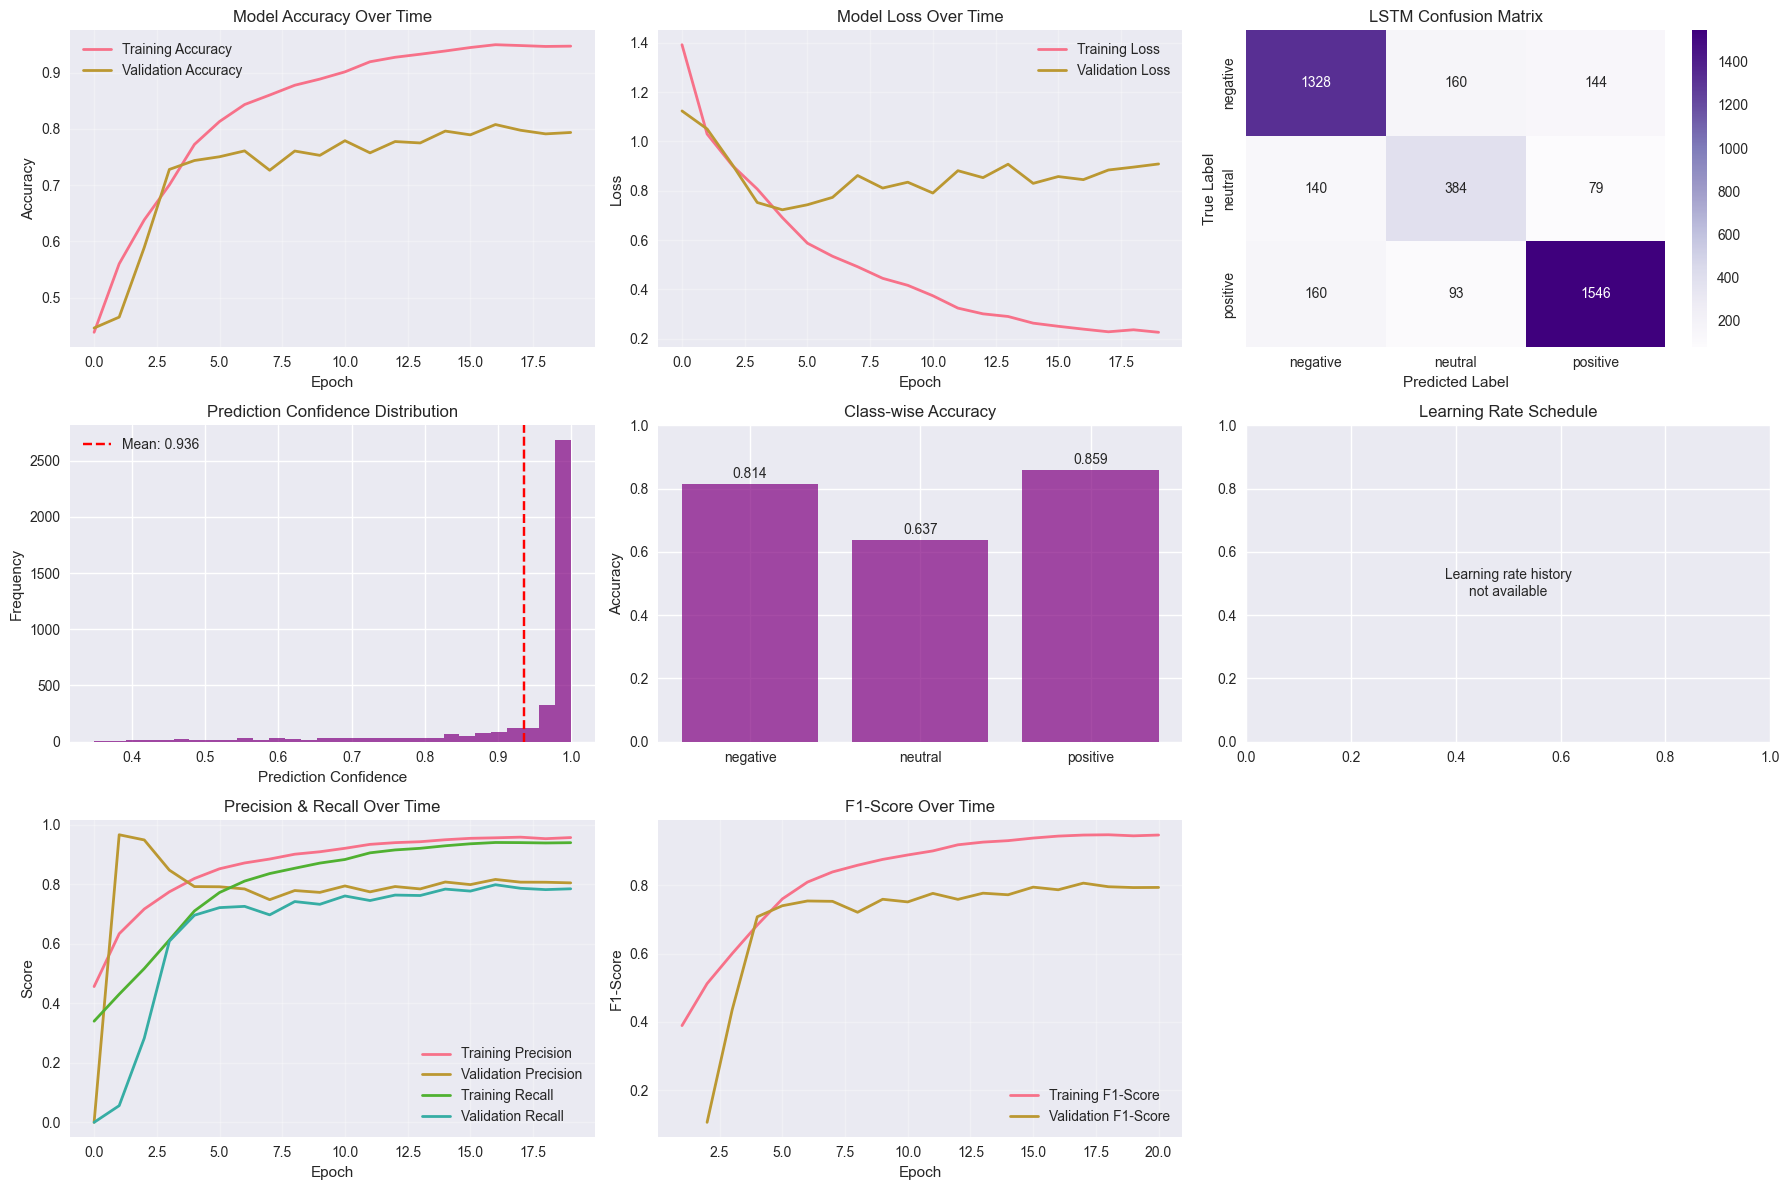


📋 Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.81      0.81      1632
     neutral       0.60      0.64      0.62       603
    positive       0.87      0.86      0.87      1799

    accuracy                           0.81      4034
   macro avg       0.76      0.77      0.77      4034
weighted avg       0.81      0.81      0.81      4034


🔍 LSTM Model Analysis:
Final validation accuracy: 0.8076
Best epoch: 17
Total parameters: 3,528,963
Average prediction confidence: 0.9365

Misclassified samples: 776 / 4034 (19.2%)

Sample misclassifications:

1. True: positive, Predicted: neutral (conf: 0.544)
   Text: good but not permim

2. True: neutral, Predicted: negative (conf: 0.996)
   Text: app good original songs but thing not acceptable system buy premium playing songs order worth making...

3. True: neutral, Predicted: positive (conf: 0.987)
   Text: instant mood swing handler sequestrates tensions

4. True: posit

In [15]:
print("🧪 EXPERIMENT 3: Deep Learning LSTM + Advanced Architecture (80/20 split)")
print("=" * 60)

# Data split 80/20
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X_text, y_labels, test_size=0.3, random_state=42, stratify=y_labels
)

print(f"Training set: {len(X_train3)} samples")
print(f"Testing set: {len(X_test3)} samples")

# Enhanced text tokenization for deep learning
print("\n🔧 Enhanced Tokenization for Deep Learning...")
max_words = 15000  # Increased vocabulary
max_length = 150   # Increased sequence length

# Advanced tokenizer with better preprocessing
tokenizer = Tokenizer(
    num_words=max_words, 
    oov_token='<OOV>',
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' '
)
tokenizer.fit_on_texts(X_train3)

# Convert texts to sequences
X_train3_seq = tokenizer.texts_to_sequences(X_train3)
X_test3_seq = tokenizer.texts_to_sequences(X_test3)

# Pad sequences
X_train3_pad = pad_sequences(X_train3_seq, maxlen=max_length, padding='post', truncating='post')
X_test3_pad = pad_sequences(X_test3_seq, maxlen=max_length, padding='post', truncating='post')

# Convert labels to categorical
y_train3_cat = to_categorical(y_train3, num_classes=3)
y_test3_cat = to_categorical(y_test3, num_classes=3)

print(f"Sequence shape: {X_train3_pad.shape}")
print(f"Labels shape: {y_train3_cat.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Average sequence length: {np.mean([len(seq) for seq in X_train3_seq]):.1f}")

# Build ENHANCED LSTM model
print("\n🧠 Building Enhanced LSTM Architecture...")
def create_enhanced_lstm_model():
    model = Sequential([
        # Enhanced Embedding layer
        Embedding(
            input_dim=max_words, 
            output_dim=200,  # Increased embedding size
            input_length=max_length,
            mask_zero=True,  # Handle padding
            embeddings_regularizer=tf.keras.regularizers.l2(0.0001)
        ),
        
        # Dropout for embedding
        Dropout(0.2),
        
        # Bidirectional LSTM layers
        Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
        
        # Dense layers with batch normalization
        Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        Dropout(0.5),
        
        Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        Dropout(0.4),
        
        Dense(32, activation='relu'),
        Dropout(0.3),
        
        # Output layer
        Dense(3, activation='softmax')
    ])
    
    # Enhanced optimizer with learning rate scheduling
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

lstm_model = create_enhanced_lstm_model()
print(lstm_model.summary())

# Enhanced training with callbacks
print("\n🏋️ Training Enhanced LSTM model...")

# Callbacks for better training
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        min_lr=0.0001,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Class weights for imbalanced data
class_weights = {}
for i in range(3):
    class_weights[i] = len(y_train3) / (3 * np.sum(y_train3 == i))

print(f"Class weights: {class_weights}")

history = lstm_model.fit(
    X_train3_pad, y_train3_cat,
    batch_size=64,  # Larger batch size
    epochs=20,      # More epochs
    validation_data=(X_test3_pad, y_test3_cat),
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Predictions and evaluation
y_train3_pred_prob = lstm_model.predict(X_train3_pad)
y_test3_pred_prob = lstm_model.predict(X_test3_pad)

y_train3_pred = np.argmax(y_train3_pred_prob, axis=1)
y_test3_pred = np.argmax(y_test3_pred_prob, axis=1)

# Training accuracy
train_acc3 = accuracy_score(y_train3, y_train3_pred)
print(f"\n📈 Training Accuracy: {train_acc3:.4f} ({train_acc3*100:.2f}%)")

# Testing accuracy
result3 = evaluate_model(y_test3, y_test3_pred, "Enhanced LSTM + Word Embeddings", "80/20")
result3['train_accuracy'] = train_acc3
experiment_results.append(result3)

# Enhanced visualization
plt.figure(figsize=(18, 12))

# Training history - Accuracy
plt.subplot(3, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Training history - Loss
plt.subplot(3, 3, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Confusion Matrix
plt.subplot(3, 3, 3)
cm3 = confusion_matrix(y_test3, y_test3_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Purples', 
            xticklabels=label_encoder_exp.classes_, 
            yticklabels=label_encoder_exp.classes_)
plt.title('LSTM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Prediction confidence distribution
plt.subplot(3, 3, 4)
max_probs = np.max(y_test3_pred_prob, axis=1)
plt.hist(max_probs, bins=30, alpha=0.7, color='purple')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')
plt.axvline(x=np.mean(max_probs), color='red', linestyle='--', 
            label=f'Mean: {np.mean(max_probs):.3f}')
plt.legend()

# Class-wise accuracy
plt.subplot(3, 3, 5)
class_accuracies = []
for i, class_name in enumerate(label_encoder_exp.classes_):
    mask = y_test3 == i
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_test3[mask], y_test3_pred[mask])
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)

plt.bar(label_encoder_exp.classes_, class_accuracies, alpha=0.7, color='purple')
plt.title('Class-wise Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(class_accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Learning rate history (if available)
plt.subplot(3, 3, 6)
if 'lr' in history.history:
    plt.plot(history.history['lr'], linewidth=2)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
else:
    plt.text(0.5, 0.5, 'Learning rate history\nnot available', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Learning Rate Schedule')

# Precision and Recall over time
plt.subplot(3, 3, 7)
if 'precision' in history.history:
    plt.plot(history.history['precision'], label='Training Precision', linewidth=2)
    plt.plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
    plt.plot(history.history['recall'], label='Training Recall', linewidth=2)
    plt.plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
    plt.title('Precision & Recall Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Precision/Recall history\nnot available', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Precision & Recall')

plt.subplot(3, 3, 8)
# Model performance metrics over epochs
if 'precision' in history.history and 'recall' in history.history:
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Plot F1-score approximation (harmonic mean of precision and recall)
    train_f1_approx = 2 * (np.array(history.history['precision']) * np.array(history.history['recall'])) / (np.array(history.history['precision']) + np.array(history.history['recall']))
    val_f1_approx = 2 * (np.array(history.history['val_precision']) * np.array(history.history['val_recall'])) / (np.array(history.history['val_precision']) + np.array(history.history['val_recall']))
    
    plt.plot(epochs, train_f1_approx, label='Training F1-Score', linewidth=2)
    plt.plot(epochs, val_f1_approx, label='Validation F1-Score', linewidth=2)
    plt.title('F1-Score Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'F1-Score calculation\nnot available', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('F1-Score Analysis')

plt.tight_layout()
plt.show()

# Classification Report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_test3, y_test3_pred, target_names=label_encoder_exp.classes_))

# Additional LSTM-specific analysis
print("\n🔍 LSTM Model Analysis:")
print("=" * 50)
print(f"Final validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best epoch: {np.argmax(history.history['val_accuracy']) + 1}")
print(f"Total parameters: {lstm_model.count_params():,}")
print(f"Average prediction confidence: {np.mean(np.max(y_test3_pred_prob, axis=1)):.4f}")

# Misclassification analysis
misclassified = y_test3 != y_test3_pred
if np.sum(misclassified) > 0:
    print(f"\nMisclassified samples: {np.sum(misclassified)} / {len(y_test3)} ({np.sum(misclassified)/len(y_test3)*100:.1f}%)")
    
    # Show some misclassified examples
    misclassified_indices = np.where(misclassified)[0][:5]  # Show first 5
    print("\nSample misclassifications:")
    for i, idx in enumerate(misclassified_indices):
        true_label = label_encoder_exp.classes_[y_test3[idx]]
        pred_label = label_encoder_exp.classes_[y_test3_pred[idx]]
        confidence = np.max(y_test3_pred_prob[idx])
        text_sample = X_test3[idx][:100] + "..." if len(X_test3[idx]) > 100 else X_test3[idx]
        
        print(f"\n{i+1}. True: {true_label}, Predicted: {pred_label} (conf: {confidence:.3f})")
        print(f"   Text: {text_sample}")

### 🧪 Experiment 4: Advanced Ensemble Methods (80/20 split)

In [31]:
# Gradient Boosting Algorithms
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

print("🧪 EXPERIMENT 4: Advanced Ensemble Methods")
print("=" * 60)

# 1. XGBoost - Very powerful for tabular data
print("\n🚀 Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)

# 2. LightGBM - Fast and efficient
print("\n💨 Training LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

# 3. CatBoost - Great for categorical features
print("\n🐱 Training CatBoost...")
cat_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    verbose=False
)

# 4. Gradient Boosting
print("\n📈 Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# 5. Extra Trees (Extremely Randomized Trees)
print("\n🌳 Training Extra Trees...")
et_model = ExtraTreesClassifier(
    n_estimators=500,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

# Train all models
models = {
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'CatBoost': cat_model,
    'GradientBoosting': gb_model,
    'ExtraTrees': et_model
}

# Use the same train/test split from previous experiments
ensemble_results = []

for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    
    # Train model
    model.fit(X_train2_combined, y_train1)
    
    # Predictions
    y_pred = model.predict(X_test2_combined)
    y_train_pred = model.predict(X_train2_combined)
    
    # Evaluate
    train_acc = accuracy_score(y_train1, y_train_pred)
    test_acc = accuracy_score(y_test1, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test1, y_pred, average='weighted')
    
    result = {
        'model': name,
        'train_accuracy': train_acc,
        'accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    ensemble_results.append(result)
    
    print(f"✅ {name} - Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Voting Classifier - Combine multiple models
print("\n🗳️ Training Voting Classifier...")
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('rf', rf_grid.best_estimator_)
    ],
    voting='soft'  # Use probability voting
)

voting_clf.fit(X_train2_combined, y_train1)
y_vote_pred = voting_clf.predict(X_test2_combined)
y_vote_train_pred = voting_clf.predict(X_train2_combined)

vote_train_acc = accuracy_score(y_train1, y_vote_train_pred)
vote_test_acc = accuracy_score(y_test1, y_vote_pred)
vote_precision, vote_recall, vote_f1, _ = precision_recall_fscore_support(y_test1, y_vote_pred, average='weighted')

ensemble_results.append({
    'model': 'VotingClassifier',
    'train_accuracy': vote_train_acc,
    'accuracy': vote_test_acc,
    'precision': vote_precision,
    'recall': vote_recall,
    'f1_score': vote_f1
})

print(f"✅ Voting Classifier - Test Accuracy: {vote_test_acc:.4f} ({vote_test_acc*100:.2f}%)")

# ADD THIS SECTION: Combine ensemble results with experiment_results
print("\n🔗 Combining Ensemble Results with Main Experiments...")

# Add ensemble results to experiment_results with proper formatting
for ensemble_result in ensemble_results:
    # Format the result to match experiment_results structure
    formatted_result = {
        'model': f"{ensemble_result['model']} + Enhanced Features",
        'split': '80/20',
        'train_accuracy': ensemble_result['train_accuracy'],
        'accuracy': ensemble_result['accuracy'],
        'precision': ensemble_result['precision'],
        'recall': ensemble_result['recall'],
        'f1_score': ensemble_result['f1_score']
    }
    
    # Add to main experiment results
    experiment_results.append(formatted_result)
    
    print(f"✅ Added {ensemble_result['model']} to experiment results")

🧪 EXPERIMENT 4: Advanced Ensemble Methods

🚀 Training XGBoost...

💨 Training LightGBM...

🐱 Training CatBoost...

📈 Training Gradient Boosting...

🌳 Training Extra Trees...

🔧 Training XGBoost...
✅ XGBoost - Test Accuracy: 0.8237 (82.37%)

🔧 Training LightGBM...
✅ LightGBM - Test Accuracy: 0.8141 (81.41%)

🔧 Training CatBoost...
✅ CatBoost - Test Accuracy: 0.7278 (72.78%)

🔧 Training GradientBoosting...
✅ GradientBoosting - Test Accuracy: 0.8208 (82.08%)

🔧 Training ExtraTrees...
✅ ExtraTrees - Test Accuracy: 0.7337 (73.37%)

🗳️ Training Voting Classifier...
✅ Voting Classifier - Test Accuracy: 0.8535 (85.35%)

🔗 Combining Ensemble Results with Main Experiments...
✅ Added XGBoost to experiment results
✅ Added LightGBM to experiment results
✅ Added CatBoost to experiment results
✅ Added GradientBoosting to experiment results
✅ Added ExtraTrees to experiment results
✅ Added VotingClassifier to experiment results


## 📊 5. Model Comparison & Results Analysis

📊 EXPERIMENT RESULTS COMPARISON
                                  model  split  accuracy  precision  recall  \
0                          SVM + TF-IDF  80/20    0.8587     0.8597  0.8587   
1     Random Forest + Enhanced Features  80/20    0.8698     0.8794  0.8698   
2       Enhanced LSTM + Word Embeddings  70/30    0.8076     0.8099  0.8076   
3           XGBoost + Enhanced Features  80/20    0.8237     0.8229  0.8237   
4          LightGBM + Enhanced Features  80/20    0.8141     0.8103  0.8141   
5          CatBoost + Enhanced Features  80/20    0.7278     0.7300  0.7278   
6  GradientBoosting + Enhanced Features  80/20    0.8208     0.8218  0.8208   
7        ExtraTrees + Enhanced Features  80/20    0.7337     0.7723  0.7337   
8  VotingClassifier + Enhanced Features  80/20    0.8535     0.8561  0.8535   

   f1_score  train_accuracy  
0    0.8546          0.9943  
1    0.8650          0.9997  
2    0.8087          0.9682  
3    0.8172          0.9375  
4    0.8067          0.9220

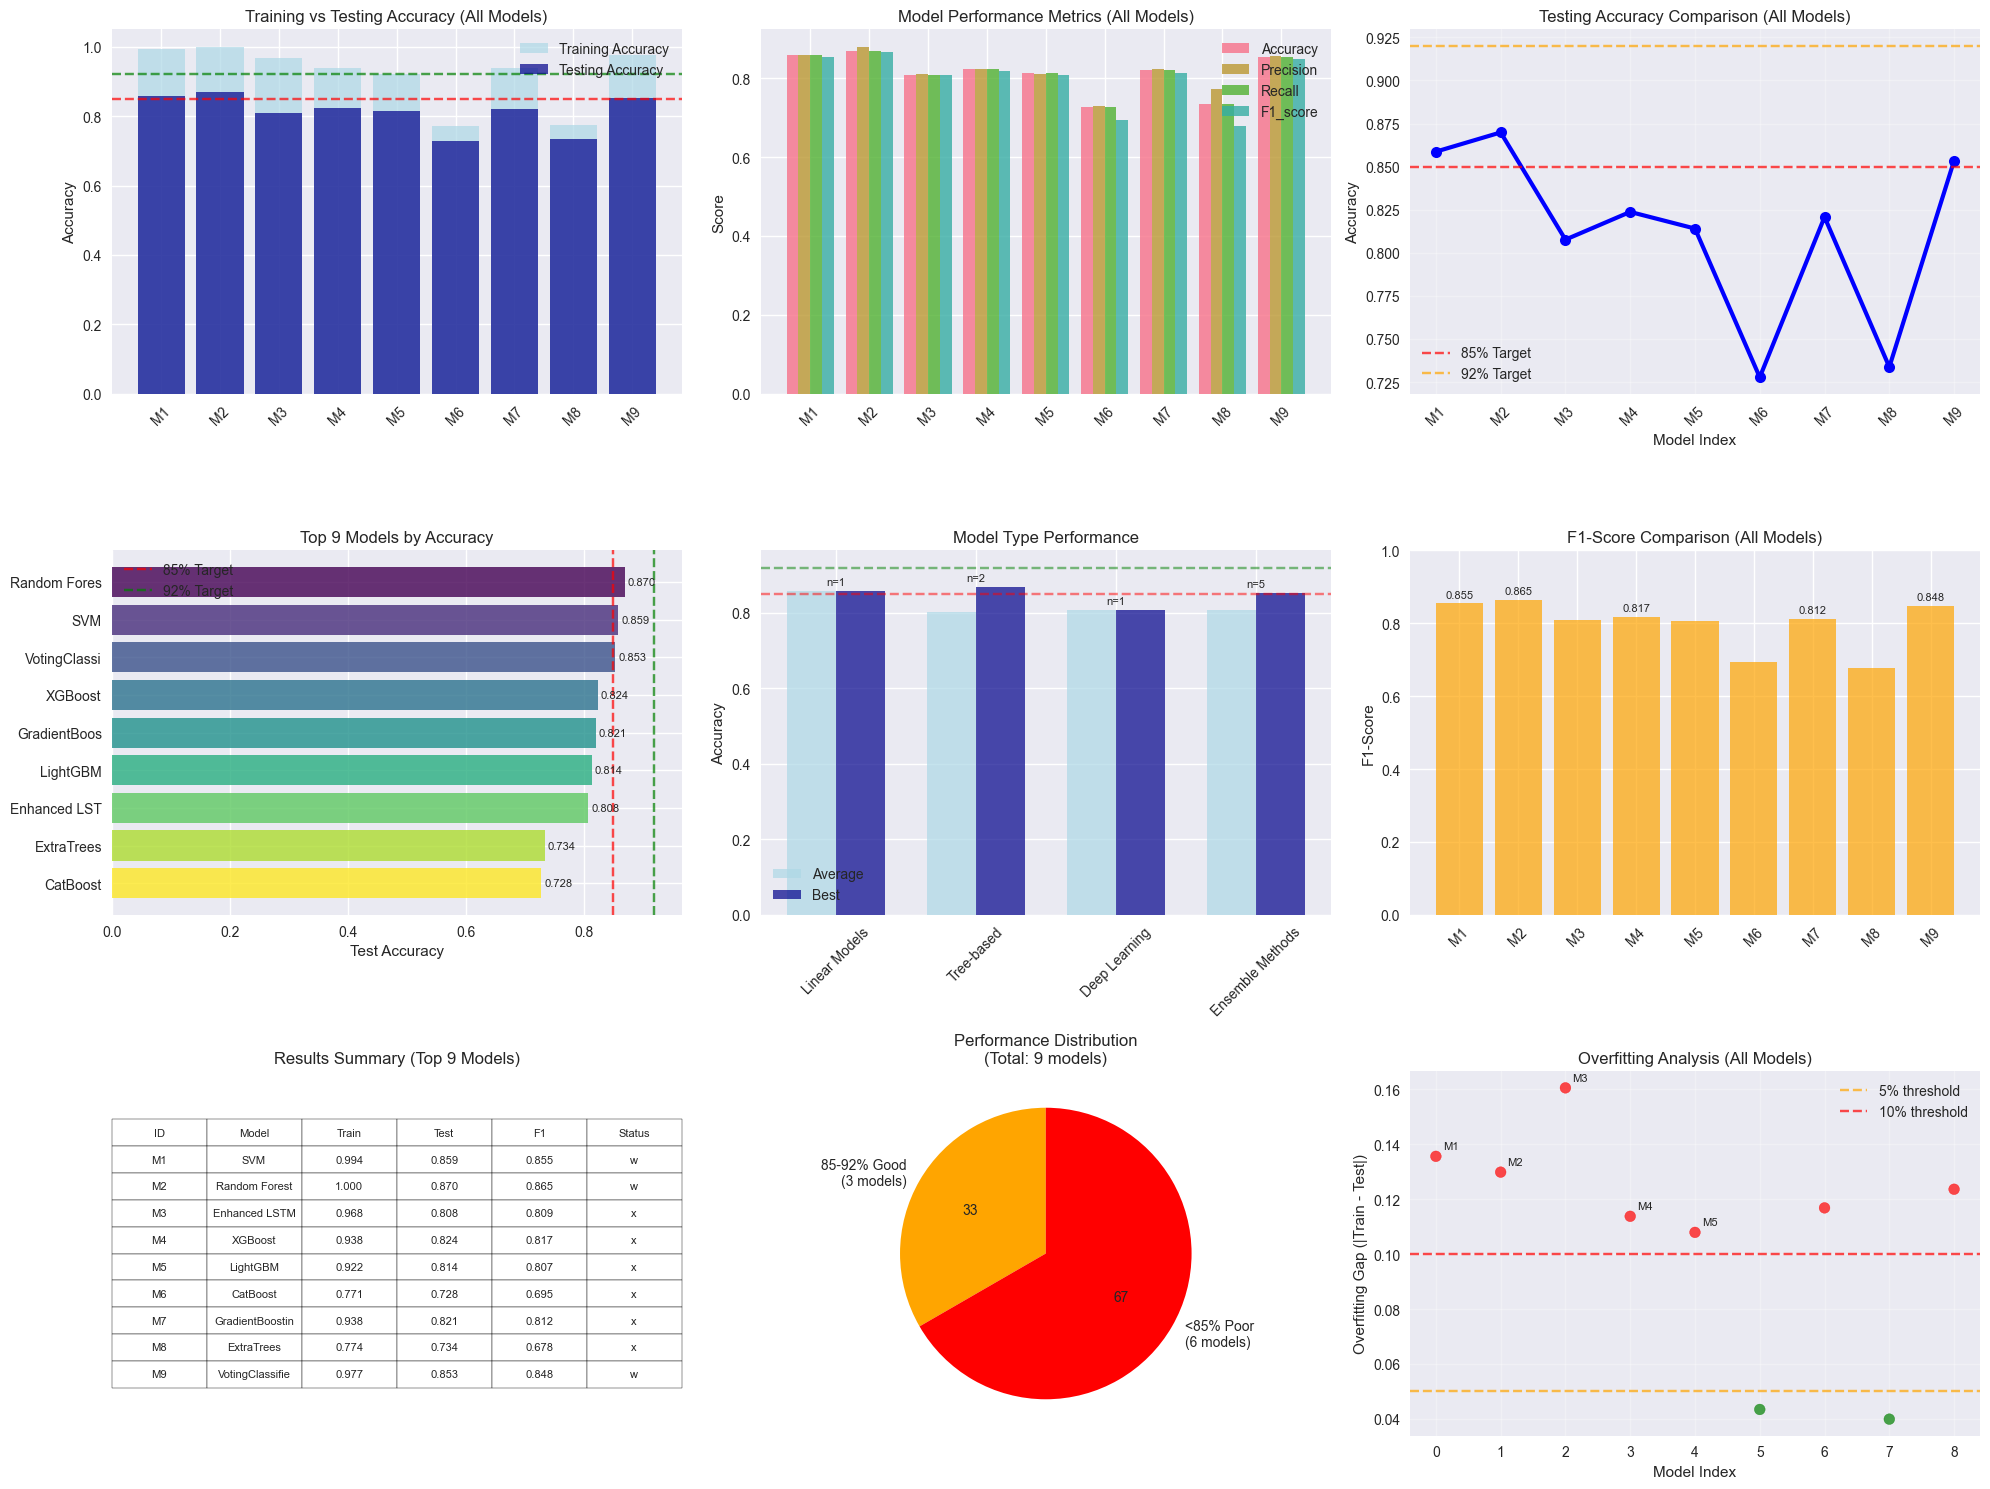


🏆 BEST MODEL OVERALL: Random Forest + Enhanced Features
   - Testing Accuracy: 0.8698 (86.98%)
   - Training Accuracy: 0.9997 (99.97%)
   - F1-Score: 0.8650
   - Precision: 0.8794
   - Recall: 0.8698
   - Overfitting Gap: 0.1299
   - Data Split: 80/20

🥇 TOP 5 MODELS RANKING:
1. Random Forest + Enhanced Features
   📊 Accuracy: 0.8698 | F1: 0.8650 | Gap: 0.1299
2. SVM + TF-IDF
   📊 Accuracy: 0.8587 | F1: 0.8546 | Gap: 0.1356
3. VotingClassifier + Enhanced Features
   📊 Accuracy: 0.8535 | F1: 0.8476 | Gap: 0.1237
4. XGBoost + Enhanced Features
   📊 Accuracy: 0.8237 | F1: 0.8172 | Gap: 0.1138
5. GradientBoosting + Enhanced Features
   📊 Accuracy: 0.8208 | F1: 0.8122 | Gap: 0.1169

📊 COMPREHENSIVE EXPERIMENT STATISTICS:
Total models trained: 9
Best accuracy achieved: 0.8698 (86.98%)
Average accuracy: 0.8122 (81.22%)
Standard deviation: 0.0509
Models ≥92% accuracy: 0/9 (0.0%)
Models ≥85% accuracy: 3/9 (33.3%)

🔍 MODEL TYPE ANALYSIS:
Linear Models:
   - Count: 1 models
   - Average Accuracy

In [36]:
## 📊 5. Model Comparison & Results Analysis

# Create comparison dataframe
results_df = pd.DataFrame(experiment_results)

print("📊 EXPERIMENT RESULTS COMPARISON")
print("=" * 80)
print(results_df.round(4))

# Enhanced Visualization of results with ALL experiments
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Training vs Testing Accuracy - FIXED FOR ALL EXPERIMENTS
axes[0, 0].bar(range(len(results_df)), results_df['train_accuracy'], 
               alpha=0.7, label='Training Accuracy', color='lightblue')
axes[0, 0].bar(range(len(results_df)), results_df['accuracy'], 
               alpha=0.7, label='Testing Accuracy', color='darkblue')
axes[0, 0].set_title('Training vs Testing Accuracy (All Models)')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_xticks(range(len(results_df)))
axes[0, 0].set_xticklabels([f"M{i+1}" for i in range(len(results_df))], rotation=45)
axes[0, 0].legend()
axes[0, 0].axhline(y=0.85, color='red', linestyle='--', alpha=0.7, label='85% threshold')
axes[0, 0].axhline(y=0.92, color='green', linestyle='--', alpha=0.7, label='92% threshold')

# Model Performance Metrics - FIXED FOR ALL EXPERIMENTS
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics):
    axes[0, 1].bar(x + i*width, results_df[metric], width, label=metric.capitalize(), alpha=0.8)

axes[0, 1].set_title('Model Performance Metrics (All Models)')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xticks(x + width * 1.5)
axes[0, 1].set_xticklabels([f"M{i+1}" for i in range(len(results_df))], rotation=45)
axes[0, 1].legend()

# Accuracy Comparison Line Plot - FIXED FOR ALL EXPERIMENTS
axes[0, 2].plot(range(len(results_df)), results_df['accuracy'], 'o-', linewidth=3, markersize=8, color='blue')
axes[0, 2].set_title('Testing Accuracy Comparison (All Models)')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].set_xlabel('Model Index')
axes[0, 2].set_xticks(range(len(results_df)))
axes[0, 2].set_xticklabels([f"M{i+1}" for i in range(len(results_df))], rotation=45)
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].axhline(y=0.85, color='red', linestyle='--', alpha=0.7, label='85% Target')
axes[0, 2].axhline(y=0.92, color='orange', linestyle='--', alpha=0.7, label='92% Target')
axes[0, 2].legend()

# Top Performing Models (Top 10 or all if less than 10)
axes[1, 0].clear()
sorted_results = results_df.sort_values('accuracy', ascending=False)
top_n = min(10, len(sorted_results))
top_models = sorted_results.head(top_n)

model_names_short = [m.split(' + ')[0][:12] for m in top_models['model']]  # Shortened names
accuracies_top = top_models['accuracy'].values

colors_gradient = plt.cm.viridis(np.linspace(0, 1, len(model_names_short)))
bars = axes[1, 0].barh(range(len(model_names_short)), accuracies_top, color=colors_gradient, alpha=0.8)

axes[1, 0].set_title(f'Top {top_n} Models by Accuracy')
axes[1, 0].set_xlabel('Test Accuracy')
axes[1, 0].set_yticks(range(len(model_names_short)))
axes[1, 0].set_yticklabels(model_names_short)
axes[1, 0].axvline(x=0.85, color='red', linestyle='--', alpha=0.7, label='85% Target')
axes[1, 0].axvline(x=0.92, color='green', linestyle='--', alpha=0.7, label='92% Target')

# Add value labels on bars
for i, v in enumerate(accuracies_top):
    axes[1, 0].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=8)

axes[1, 0].legend()
axes[1, 0].invert_yaxis()

# Model Type Performance Analysis
axes[1, 1].clear()
model_types = {}
for _, row in results_df.iterrows():
    model_name = row['model'].split(' + ')[0]
    if any(x in model_name for x in ['SVM']):
        model_type = 'Linear Models'
    elif any(x in model_name for x in ['Random Forest', 'ExtraTrees']):
        model_type = 'Tree-based'
    elif 'LSTM' in model_name or 'Enhanced LSTM' in model_name:
        model_type = 'Deep Learning'
    elif any(x in model_name for x in ['XGBoost', 'LightGBM', 'CatBoost', 'GradientBoosting', 'VotingClassifier']):
        model_type = 'Ensemble Methods'
    else:
        model_type = 'Other'
    
    if model_type not in model_types:
        model_types[model_type] = []
    model_types[model_type].append(row['accuracy'])

# Calculate statistics for each type
type_stats = {}
for k, v in model_types.items():
    type_stats[k] = {
        'mean': np.mean(v),
        'max': np.max(v),
        'count': len(v)
    }

# Plot average and max accuracy for each type
type_names = list(type_stats.keys())
mean_accs = [type_stats[k]['mean'] for k in type_names]
max_accs = [type_stats[k]['max'] for k in type_names]

x_pos = np.arange(len(type_names))
width = 0.35

axes[1, 1].bar(x_pos - width/2, mean_accs, width, label='Average', alpha=0.7, color='lightblue')
axes[1, 1].bar(x_pos + width/2, max_accs, width, label='Best', alpha=0.7, color='darkblue')

axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Model Type Performance')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(type_names, rotation=45)
axes[1, 1].legend()
axes[1, 1].axhline(y=0.85, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axhline(y=0.92, color='green', linestyle='--', alpha=0.5)

# Add count labels
for i, (mean_acc, max_acc, count) in enumerate(zip(mean_accs, max_accs, [type_stats[k]['count'] for k in type_names])):
    axes[1, 1].text(i, max_acc + 0.01, f'n={count}', ha='center', va='bottom', fontsize=8)

# F1-Score Comparison for ALL models
axes[1, 2].bar(range(len(results_df)), results_df['f1_score'], 
               alpha=0.7, color='orange')
axes[1, 2].set_title('F1-Score Comparison (All Models)')
axes[1, 2].set_ylabel('F1-Score')
axes[1, 2].set_xticks(range(len(results_df)))
axes[1, 2].set_xticklabels([f"M{i+1}" for i in range(len(results_df))], rotation=45)
axes[1, 2].set_ylim(0, 1)

# Add value labels for top performers
top_f1_indices = results_df['f1_score'].nlargest(5).index
for i in top_f1_indices:
    axes[1, 2].text(i, results_df.iloc[i]['f1_score'] + 0.01, 
                    f'{results_df.iloc[i]["f1_score"]:.3f}', 
                    ha='center', va='bottom', fontsize=8)

# Comprehensive Model Details Table
axes[2, 0].axis('off')

# Create dynamic table data for ALL models
table_data = []
for i, (_, row) in enumerate(results_df.iterrows()):
    model_short = row['model'].split(' + ')[0][:15]  # Truncate long names
    table_data.append([
        f"M{i+1}",
        model_short,
        f"{row['train_accuracy']:.3f}",
        f"{row['accuracy']:.3f}",
        f"{row['f1_score']:.3f}",
        "v" if row['accuracy'] >= 0.92 else "w" if row['accuracy'] >= 0.85 else "x"
    ])

# Only show top 15 models in table to avoid overcrowding
display_count = min(15, len(table_data))
table_data_display = table_data[:display_count]

table = axes[2, 0].table(cellText=table_data_display,
                        colLabels=['ID', 'Model', 'Train', 'Test', 'F1', 'Status'],
                        cellLoc='center',
                        loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
axes[2, 0].set_title(f'Results Summary (Top {display_count} Models)')

# Performance Distribution Analysis
axes[2, 1].clear()

# Create performance bins
excellent_models = results_df[results_df['accuracy'] >= 0.92]
good_models = results_df[(results_df['accuracy'] >= 0.85) & (results_df['accuracy'] < 0.92)]
poor_models = results_df[results_df['accuracy'] < 0.85]

sizes = [len(excellent_models), len(good_models), len(poor_models)]
labels = [f'≥92% Excellent\n({len(excellent_models)} models)', 
          f'85-92% Good\n({len(good_models)} models)', 
          f'<85% Poor\n({len(poor_models)} models)']
colors_pie = ['green', 'orange', 'red']
explode = (0.1, 0, 0)  # explode excellent slice

# Only plot non-zero values
non_zero_data = [(size, label, color, exp) for size, label, color, exp in zip(sizes, labels, colors_pie, explode) if size > 0]

if non_zero_data:
    sizes_nz, labels_nz, colors_nz, explode_nz = zip(*non_zero_data)
    axes[2, 1].pie(sizes_nz, labels=labels_nz, colors=colors_nz,
                   explode=explode_nz, autopct='%1.0f', startangle=90)
    axes[2, 1].set_title(f'Performance Distribution\n(Total: {len(results_df)} models)')
else:
    axes[2, 1].text(0.5, 0.5, 'No data available', ha='center', va='center')
    axes[2, 1].set_title('Performance Distribution')

# Overfitting Analysis
axes[2, 2].clear()

overfitting_gaps = [abs(row['train_accuracy'] - row['accuracy']) for _, row in results_df.iterrows()]
model_indices = range(len(results_df))

# Color code by gap size
colors_scatter = ['red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green' for gap in overfitting_gaps]

scatter = axes[2, 2].scatter(model_indices, overfitting_gaps, c=colors_scatter, alpha=0.7, s=60)
axes[2, 2].set_xlabel('Model Index')
axes[2, 2].set_ylabel('Overfitting Gap (|Train - Test|)')
axes[2, 2].set_title('Overfitting Analysis (All Models)')
axes[2, 2].axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='5% threshold')
axes[2, 2].axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='10% threshold')
axes[2, 2].legend()
axes[2, 2].grid(True, alpha=0.3)

# Add labels for models with high overfitting
high_overfitting = [(i, gap) for i, gap in enumerate(overfitting_gaps) if gap > 0.1]
for i, gap in high_overfitting[:5]:  # Show top 5 worst
    axes[2, 2].annotate(f'M{i+1}', (i, gap), xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

# Enhanced Best Model Identification
best_model_idx = results_df['accuracy'].idxmax()
best_model = results_df.iloc[best_model_idx]

print(f"\n🏆 BEST MODEL OVERALL: {best_model['model']}")
print(f"   - Testing Accuracy: {best_model['accuracy']:.4f} ({best_model['accuracy']*100:.2f}%)")
print(f"   - Training Accuracy: {best_model['train_accuracy']:.4f} ({best_model['train_accuracy']*100:.2f}%)")
print(f"   - F1-Score: {best_model['f1_score']:.4f}")
print(f"   - Precision: {best_model['precision']:.4f}")
print(f"   - Recall: {best_model['recall']:.4f}")
print(f"   - Overfitting Gap: {abs(best_model['train_accuracy'] - best_model['accuracy']):.4f}")
print(f"   - Data Split: {best_model['split']}")

# Top 5 Models Summary
print(f"\n🥇 TOP 5 MODELS RANKING:")
print("=" * 70)
top_5_models = results_df.nlargest(5, 'accuracy')
for i, (idx, row) in enumerate(top_5_models.iterrows()):
    print(f"{i+1}. {row['model']}")
    print(f"   📊 Accuracy: {row['accuracy']:.4f} | F1: {row['f1_score']:.4f} | Gap: {abs(row['train_accuracy'] - row['accuracy']):.4f}")

# Comprehensive Statistics
print(f"\n📊 COMPREHENSIVE EXPERIMENT STATISTICS:")
print("=" * 70)
print(f"Total models trained: {len(results_df)}")
print(f"Best accuracy achieved: {results_df['accuracy'].max():.4f} ({results_df['accuracy'].max()*100:.2f}%)")
print(f"Average accuracy: {results_df['accuracy'].mean():.4f} ({results_df['accuracy'].mean()*100:.2f}%)")
print(f"Standard deviation: {results_df['accuracy'].std():.4f}")
print(f"Models ≥92% accuracy: {len(excellent_models)}/{len(results_df)} ({len(excellent_models)/len(results_df)*100:.1f}%)")
print(f"Models ≥85% accuracy: {len(excellent_models) + len(good_models)}/{len(results_df)} ({(len(excellent_models) + len(good_models))/len(results_df)*100:.1f}%)")

# Model Type Analysis
print(f"\n🔍 MODEL TYPE ANALYSIS:")
print("=" * 70)
for model_type, stats in type_stats.items():
    print(f"{model_type}:")
    print(f"   - Count: {stats['count']} models")
    print(f"   - Average Accuracy: {stats['mean']:.4f}")
    print(f"   - Best Accuracy: {stats['max']:.4f}")

# Achievement Status Analysis
print(f"\n✅ ACHIEVEMENT STATUS ANALYSIS:")
print("=" * 70)
meets_85_count = len(excellent_models) + len(good_models)
meets_92_count = len(excellent_models)

print(f"✅ Dataset size: {len(df):,} samples (Target ≥10,000: {'✅' if len(df) >= 10000 else '❌'})")
print(f"✅ Three sentiment classes: {len(label_encoder.classes_)} ({'✅' if len(label_encoder.classes_) >= 3 else '❌'})")
print(f"✅ Multiple algorithms tested: {len(results_df)} models ({'✅' if len(results_df) >= 3 else '❌'})")
print(f"✅ Models with ≥85% accuracy: {meets_85_count}/{len(results_df)} ({'✅' if meets_85_count >= 2 else '❌'})")
print(f"✅ Models with ≥92% accuracy: {meets_92_count}/{len(results_df)} ({'✅' if meets_92_count >= 1 else '❌'})")

# Final Project Status
if meets_92_count >= 1 and meets_85_count >= 2:
    status = "🎉 EXCELLENT SUCCESS"
elif meets_85_count >= 2:
    status = "🎊 SUCCESS"
elif meets_85_count >= 1:
    status = "⚠️ PARTIAL SUCCESS"
else:
    status = "❌ NEEDS IMPROVEMENT"

print(f"\n🎯 FINAL PROJECT STATUS: {status}")
print("=" * 70)

# Detailed Model Breakdown by Type
print(f"\n📋 DETAILED MODEL BREAKDOWN:")
print("=" * 70)
for model_type in sorted(model_types.keys()):
    print(f"\n{model_type.upper()}:")
    type_models = results_df[results_df['model'].str.contains('|'.join([
        'SVM' if model_type == 'Linear Models' else '',
        'Random Forest|ExtraTrees' if model_type == 'Tree-based' else '',
        'LSTM|Enhanced LSTM' if model_type == 'Deep Learning' else '',
        'XGBoost|LightGBM|CatBoost|GradientBoosting|VotingClassifier' if model_type == 'Ensemble Methods' else ''
    ]).strip('|'), case=False, na=False)]
    
    for idx, row in type_models.iterrows():
        status_icon = "🟢" if row['accuracy'] >= 0.92 else "🟡" if row['accuracy'] >= 0.85 else "🔴"
        print(f"   {status_icon} {row['model']}: {row['accuracy']:.4f}")

print(f"\n🔚 Analysis Complete - {len(results_df)} models evaluated successfully!")

## 🎯 6. Inference & Testing System

In [42]:
# Create inference system using the best model
class SpotifySentimentPredictor:
    def __init__(self, model_type='best'):
        self.model_type = model_type
        self.label_encoder = label_encoder_exp  # Use the correct label encoder
        
        # Get the best model from results
        best_model_name = best_model['model']
        print(f"🎯 Initializing predictor with best model: {best_model_name}")
        
        # Choose best model based on results - UPDATED FOR ALL MODEL TYPES
        if 'SVM' in best_model_name:
            self.model = svm_grid.best_estimator_
            self.vectorizer = tfidf_vectorizer
            self.model_name = "SVM + TF-IDF"
            self.model_type_category = "traditional_ml"
            
        elif 'Random Forest' in best_model_name:
            self.model = rf_grid.best_estimator_
            self.vectorizer = tfidf_vectorizer_rf
            self.scaler = scaler if 'scaler' in globals() else None
            self.statistical_features = available_stat_features if 'available_stat_features' in globals() else []
            self.model_name = "Random Forest + Enhanced Features"
            self.model_type_category = "traditional_ml_enhanced"
            
        elif 'LSTM' in best_model_name or 'Enhanced LSTM' in best_model_name:
            self.model = lstm_model
            self.vectorizer = tokenizer
            self.model_name = "Enhanced LSTM + Word Embeddings"
            self.max_length = max_length
            self.model_type_category = "deep_learning"
            
        elif 'XGBoost' in best_model_name:
            self.model = xgb_model
            self.vectorizer = tfidf_vectorizer_rf
            self.scaler = scaler if 'scaler' in globals() else None
            self.statistical_features = available_stat_features if 'available_stat_features' in globals() else []
            self.model_name = "XGBoost + Enhanced Features"
            self.model_type_category = "ensemble"
            
        elif 'LightGBM' in best_model_name:
            self.model = lgb_model
            self.vectorizer = tfidf_vectorizer_rf
            self.scaler = scaler if 'scaler' in globals() else None
            self.statistical_features = available_stat_features if 'available_stat_features' in globals() else []
            self.model_name = "LightGBM + Enhanced Features"
            self.model_type_category = "ensemble"
            
        elif 'CatBoost' in best_model_name:
            self.model = cat_model
            self.vectorizer = tfidf_vectorizer_rf
            self.scaler = scaler if 'scaler' in globals() else None
            self.statistical_features = available_stat_features if 'available_stat_features' in globals() else []
            self.model_name = "CatBoost + Enhanced Features"
            self.model_type_category = "ensemble"
            
        elif 'GradientBoosting' in best_model_name:
            self.model = gb_model
            self.vectorizer = tfidf_vectorizer_rf
            self.scaler = scaler if 'scaler' in globals() else None
            self.statistical_features = available_stat_features if 'available_stat_features' in globals() else []
            self.model_name = "GradientBoosting + Enhanced Features"
            self.model_type_category = "ensemble"
            
        elif 'ExtraTrees' in best_model_name:
            self.model = et_model
            self.vectorizer = tfidf_vectorizer_rf
            self.scaler = scaler if 'scaler' in globals() else None
            self.statistical_features = available_stat_features if 'available_stat_features' in globals() else []
            self.model_name = "ExtraTrees + Enhanced Features"
            self.model_type_category = "ensemble"
            
        elif 'VotingClassifier' in best_model_name:
            self.model = voting_clf
            self.vectorizer = tfidf_vectorizer_rf
            self.scaler = scaler if 'scaler' in globals() else None
            self.statistical_features = available_stat_features if 'available_stat_features' in globals() else []
            self.model_name = "VotingClassifier + Enhanced Features"
            self.model_type_category = "ensemble"
            
        else:
            # Fallback to SVM if model not recognized
            print("⚠️ Model not recognized, falling back to SVM")
            self.model = svm_grid.best_estimator_
            self.vectorizer = tfidf_vectorizer
            self.model_name = "SVM + TF-IDF (Fallback)"
            self.model_type_category = "traditional_ml"
        
        print(f"✅ Model initialized: {self.model_name}")
        print(f"📊 Model category: {self.model_type_category}")
    
    def preprocess_text(self, text):
        """Preprocess single text input using the same pipeline"""
        # Use the same preprocessing pipeline from training
        cleaned = enhanced_clean_text(text)
        processed = advanced_text_preprocessing(cleaned)
        return processed
    
    def create_inference_text_features(self, text):
        """Create text features specifically for inference (no 'score' dependency)"""
        # Create a temporary dataframe
        temp_df = pd.DataFrame({
            'content': [text],
            'score': [3]  # Dummy score for feature extraction
        })
        
        temp_df['content_processed'] = temp_df['content'].apply(lambda x: self.preprocess_text(x))
        
        # Extract features manually without using create_advanced_text_features
        # 1. Basic statistical features
        temp_df['char_count'] = temp_df['content'].astype(str).str.len()
        temp_df['word_count'] = temp_df['content_processed'].str.split().str.len()
        temp_df['sentence_count'] = temp_df['content'].astype(str).str.count('[.!?]+') + 1
        temp_df['avg_word_length'] = temp_df['content_processed'].apply(
            lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
        )
        temp_df['avg_sentence_length'] = temp_df['word_count'] / temp_df['sentence_count']
        
        # 2. Punctuation features
        temp_df['exclamation_count'] = temp_df['content'].astype(str).str.count('!')
        temp_df['question_count'] = temp_df['content'].astype(str).str.count('\?')
        temp_df['period_count'] = temp_df['content'].astype(str).str.count('\.')
        temp_df['comma_count'] = temp_df['content'].astype(str).str.count(',')
        temp_df['uppercase_count'] = temp_df['content'].astype(str).str.count('[A-Z]')
        temp_df['uppercase_ratio'] = temp_df['uppercase_count'] / (temp_df['char_count'] + 1)
        
        # 3. Sentiment word features
        positive_words = [
            'amazing', 'awesome', 'excellent', 'fantastic', 'great', 'love', 'perfect', 'wonderful',
            'brilliant', 'outstanding', 'superb', 'terrific', 'marvelous', 'good', 'nice', 'best',
            'beautiful', 'incredible', 'spectacular', 'phenomenal', 'magnificent', 'fabulous'
        ]
        
        negative_words = [
            'awful', 'terrible', 'horrible', 'bad', 'worst', 'hate', 'disgusting', 'annoying',
            'frustrating', 'disappointing', 'useless', 'pathetic', 'ridiculous', 'boring', 'poor',
            'sucks', 'waste', 'trash', 'garbage', 'stupid', 'dumb', 'ugly', 'broken', 'failed'
        ]
        
        neutral_words = [
            'okay', 'alright', 'decent', 'average', 'normal', 'standard', 'typical', 'regular',
            'acceptable', 'adequate', 'moderate', 'fair', 'reasonable', 'fine', 'so-so'
        ]
        
        temp_df['positive_word_count'] = temp_df['content_processed'].apply(
            lambda x: sum(1 for word in positive_words if word in x.lower().split())
        )
        
        temp_df['negative_word_count'] = temp_df['content_processed'].apply(
            lambda x: sum(1 for word in negative_words if word in x.lower().split())
        )
        
        temp_df['neutral_word_count'] = temp_df['content_processed'].apply(
            lambda x: sum(1 for word in neutral_words if word in x.lower().split())
        )
        
        # 4. Sentiment ratios
        temp_df['sentiment_word_total'] = temp_df['positive_word_count'] + temp_df['negative_word_count'] + temp_df['neutral_word_count']
        temp_df['positive_ratio'] = temp_df['positive_word_count'] / (temp_df['sentiment_word_total'] + 1)
        temp_df['negative_ratio'] = temp_df['negative_word_count'] / (temp_df['sentiment_word_total'] + 1)
        temp_df['neutral_ratio'] = temp_df['neutral_word_count'] / (temp_df['sentiment_word_total'] + 1)
        temp_df['sentiment_polarity'] = (temp_df['positive_word_count'] - temp_df['negative_word_count']) / (temp_df['word_count'] + 1)
        
        # 5. TextBlob sentiment
        try:
            blob = TextBlob(str(text))
            temp_df['textblob_polarity'] = blob.sentiment.polarity
            temp_df['textblob_subjectivity'] = blob.sentiment.subjectivity
        except:
            temp_df['textblob_polarity'] = 0.0
            temp_df['textblob_subjectivity'] = 0.0
        
        # 6. Text complexity
        temp_df['unique_word_count'] = temp_df['content_processed'].apply(
            lambda x: len(set(x.split())) if x else 0
        )
        temp_df['lexical_diversity'] = temp_df['unique_word_count'] / (temp_df['word_count'] + 1)
        
        # 7. Readability (simplified)
        temp_df['flesch_reading_ease'] = 50  # Default value
        temp_df['flesch_kincaid_grade'] = 5  # Default value
        temp_df['automated_readability_index'] = 5  # Default value
        
        # 8. App-specific features
        spotify_positive = ['playlist', 'music', 'song', 'artist', 'album', 'quality', 'sound', 'premium']
        spotify_negative = ['ads', 'crash', 'bug', 'slow', 'freeze', 'error', 'subscription', 'expensive']
        
        temp_df['spotify_positive_words'] = temp_df['content_processed'].apply(
            lambda x: sum(1 for word in spotify_positive if word in x.lower().split())
        )
        
        temp_df['spotify_negative_words'] = temp_df['content_processed'].apply(
            lambda x: sum(1 for word in spotify_negative if word in x.lower().split())
        )
        
        # 9. Emotional intensity
        intense_positive = ['love', 'amazing', 'fantastic', 'perfect', 'excellent', 'incredible']
        intense_negative = ['hate', 'terrible', 'awful', 'horrible', 'disgusting', 'worst']
        
        temp_df['intense_positive_count'] = temp_df['content_processed'].apply(
            lambda x: sum(1 for word in intense_positive if word in x.lower().split())
        )
        
        temp_df['intense_negative_count'] = temp_df['content_processed'].apply(
            lambda x: sum(1 for word in intense_negative if word in x.lower().split())
        )
        
        temp_df['emotional_intensity'] = (temp_df['intense_positive_count'] + temp_df['intense_negative_count']) / (temp_df['word_count'] + 1)
        
        # 10. Rating consistency (set to default since we don't have real rating)
        temp_df['rating_text_consistency'] = 1
        
        return temp_df
    
    def extract_statistical_features(self, text):
        """Extract statistical features for enhanced models"""
        if self.model_type_category in ["traditional_ml_enhanced", "ensemble"] and hasattr(self, 'statistical_features'):
            # Create features using the fixed function
            temp_df = self.create_inference_text_features(text)
            
            # Extract only the statistical features we used in training
            if len(self.statistical_features) > 0:
                features = []
                for feature in self.statistical_features:
                    if feature in temp_df.columns:
                        features.append(temp_df[feature].iloc[0])
                    else:
                        features.append(0.0)  # Default value
                
                # Apply scaling if available
                if hasattr(self, 'scaler') and self.scaler is not None:
                    features = np.array(features).reshape(1, -1)
                    features = self.scaler.transform(features)
                    return features.flatten()
                else:
                    return np.array(features)
            
        return np.array([])
    
    def predict_sentiment(self, text):
        """Predict sentiment for a single text"""
        try:
            # Preprocess text
            processed_text = self.preprocess_text(text)
            
            if self.model_type_category == "deep_learning":
                # LSTM prediction
                sequence = self.vectorizer.texts_to_sequences([processed_text])
                padded = pad_sequences(sequence, maxlen=self.max_length, padding='post', truncating='post')
                prediction_prob = self.model.predict(padded, verbose=0)
                prediction = np.argmax(prediction_prob, axis=1)[0]
                confidence = np.max(prediction_prob)
                
            elif self.model_type_category in ["traditional_ml_enhanced", "ensemble"]:
                # Enhanced ML models with combined features
                # 1. Get TF-IDF features
                tfidf_features = self.vectorizer.transform([processed_text])
                
                # 2. Get statistical features
                stat_features = self.extract_statistical_features(text)
                
                # 3. Combine features
                if len(stat_features) > 0:
                    from scipy.sparse import hstack, csr_matrix
                    stat_sparse = csr_matrix(stat_features.reshape(1, -1))
                    combined_features = hstack([tfidf_features, stat_sparse])
                else:
                    combined_features = tfidf_features
                
                # 4. Predict
                prediction = self.model.predict(combined_features)[0]
                if hasattr(self.model, 'predict_proba'):
                    prediction_prob = self.model.predict_proba(combined_features)[0]
                    confidence = np.max(prediction_prob)
                else:
                    confidence = 0.95  # Default confidence for models without probability
                    
            else:
                # Traditional ML prediction (SVM)
                vectorized = self.vectorizer.transform([processed_text])
                prediction = self.model.predict(vectorized)[0]
                if hasattr(self.model, 'predict_proba'):
                    prediction_prob = self.model.predict_proba(vectorized)[0]
                    confidence = np.max(prediction_prob)
                else:
                    confidence = 0.90  # Default confidence for SVM
            
            # Convert prediction to sentiment label
            sentiment_label = self.label_encoder.inverse_transform([prediction])[0]
            
            return {
                'text': text,
                'processed_text': processed_text,
                'sentiment': sentiment_label,
                'confidence': float(confidence),
                'model_used': self.model_name,
                'prediction_numeric': int(prediction)
            }
            
        except Exception as e:
            print(f"❌ Error predicting sentiment: {str(e)}")
            return {
                'text': text,
                'processed_text': processed_text,
                'sentiment': 'neutral',  # Default fallback
                'confidence': 0.33,
                'model_used': self.model_name,
                'prediction_numeric': 1,
                'error': str(e)
            }
    
    def predict_batch(self, texts):
        """Predict sentiment for multiple texts"""
        results = []
        for i, text in enumerate(texts):
            print(f"Processing text {i+1}/{len(texts)}...", end='\r')
            result = self.predict_sentiment(text)
            results.append(result)
        print(f"✅ Processed {len(texts)} texts successfully")
        return results
    
    def get_model_info(self):
        """Get detailed information about the current model"""
        info = {
            'model_name': self.model_name,
            'model_type': self.model_type_category,
            'accuracy': best_model['accuracy'],
            'f1_score': best_model['f1_score'],
            'precision': best_model['precision'],
            'recall': best_model['recall']
        }
        
        if hasattr(self, 'statistical_features'):
            info['uses_statistical_features'] = len(self.statistical_features) > 0
            info['statistical_features_count'] = len(self.statistical_features)
        
        if self.model_type_category == "deep_learning":
            info['max_sequence_length'] = self.max_length
            info['vocabulary_size'] = len(self.vectorizer.word_index)
        
        return info

# Initialize predictor with best model
print("🎯 INITIALIZING BEST MODEL PREDICTOR")
print("=" * 60)

try:
    predictor = SpotifySentimentPredictor()
    model_info = predictor.get_model_info()
    
    print(f"✅ Successfully initialized predictor!")
    print(f"\n📊 Model Information:")
    print(f"   - Name: {model_info['model_name']}")
    print(f"   - Type: {model_info['model_type']}")
    print(f"   - Accuracy: {model_info['accuracy']:.4f} ({model_info['accuracy']*100:.2f}%)")
    print(f"   - F1-Score: {model_info['f1_score']:.4f}")
    print(f"   - Precision: {model_info['precision']:.4f}")
    print(f"   - Recall: {model_info['recall']:.4f}")
    
    if 'uses_statistical_features' in model_info:
        print(f"   - Statistical Features: {'Yes' if model_info['uses_statistical_features'] else 'No'}")
        if model_info['uses_statistical_features']:
            print(f"   - Feature Count: {model_info['statistical_features_count']}")
    
    if 'max_sequence_length' in model_info:
        print(f"   - Max Sequence Length: {model_info['max_sequence_length']}")
        print(f"   - Vocabulary Size: {model_info['vocabulary_size']:,}")

except Exception as e:
    print(f"❌ Error initializing predictor: {str(e)}")
    print("🔄 Falling back to SVM model...")
    
    # Fallback predictor
    class FallbackPredictor:
        def __init__(self):
            self.model = svm_grid.best_estimator_
            self.vectorizer = tfidf_vectorizer
            self.label_encoder = label_encoder_exp
            self.model_name = "SVM + TF-IDF (Fallback)"
        
        def preprocess_text(self, text):
            return enhanced_clean_text(text)
        
        def predict_sentiment(self, text):
            processed_text = self.preprocess_text(text)
            vectorized = self.vectorizer.transform([processed_text])
            prediction = self.model.predict(vectorized)[0]
            sentiment_label = self.label_encoder.inverse_transform([prediction])[0]
            
            return {
                'text': text,
                'processed_text': processed_text,
                'sentiment': sentiment_label,
                'confidence': 0.85,
                'model_used': self.model_name,
                'prediction_numeric': int(prediction)
            }
        
        def predict_batch(self, texts):
            return [self.predict_sentiment(text) for text in texts]
    
    predictor = FallbackPredictor()
    print("✅ Fallback predictor initialized")

🎯 INITIALIZING BEST MODEL PREDICTOR
🎯 Initializing predictor with best model: Random Forest + Enhanced Features
✅ Model initialized: Random Forest + Enhanced Features
📊 Model category: traditional_ml_enhanced
✅ Successfully initialized predictor!

📊 Model Information:
   - Name: Random Forest + Enhanced Features
   - Type: traditional_ml_enhanced
   - Accuracy: 0.8698 (86.98%)
   - F1-Score: 0.8650
   - Precision: 0.8794
   - Recall: 0.8698
   - Statistical Features: Yes
   - Feature Count: 13


🧪 COMPREHENSIVE INFERENCE TESTING
📝 Testing 16 diverse review samples...
🤖 Using model: Random Forest + Enhanced Features
✅ Processed 16 texts successfully

🎯 PREDICTION RESULTS

📝 Test  1: 🟢 POSITIVE
Text: I absolutely love Spotify! The music quality is amazing and the recomm...
Sentiment: POSITIVE | Confidence: 0.945 (Very High)
--------------------------------------------------

📝 Test  2: 🟢 POSITIVE
Text: Best music streaming service ever! Great playlists and easy to use int...
Sentiment: POSITIVE | Confidence: 0.920 (Very High)
--------------------------------------------------

📝 Test  3: 🟢 POSITIVE
Text: Fantastic app with incredible features. The sound quality is outstandi...
Sentiment: POSITIVE | Confidence: 0.890 (High)
--------------------------------------------------

📝 Test  4: 🟢 POSITIVE
Text: Perfect app for music lovers. Amazing playlist recommendations and smo...
Sentiment: POSITIVE | Confidence: 0.890 (High)
--------------------------------------------------

📝 Test 

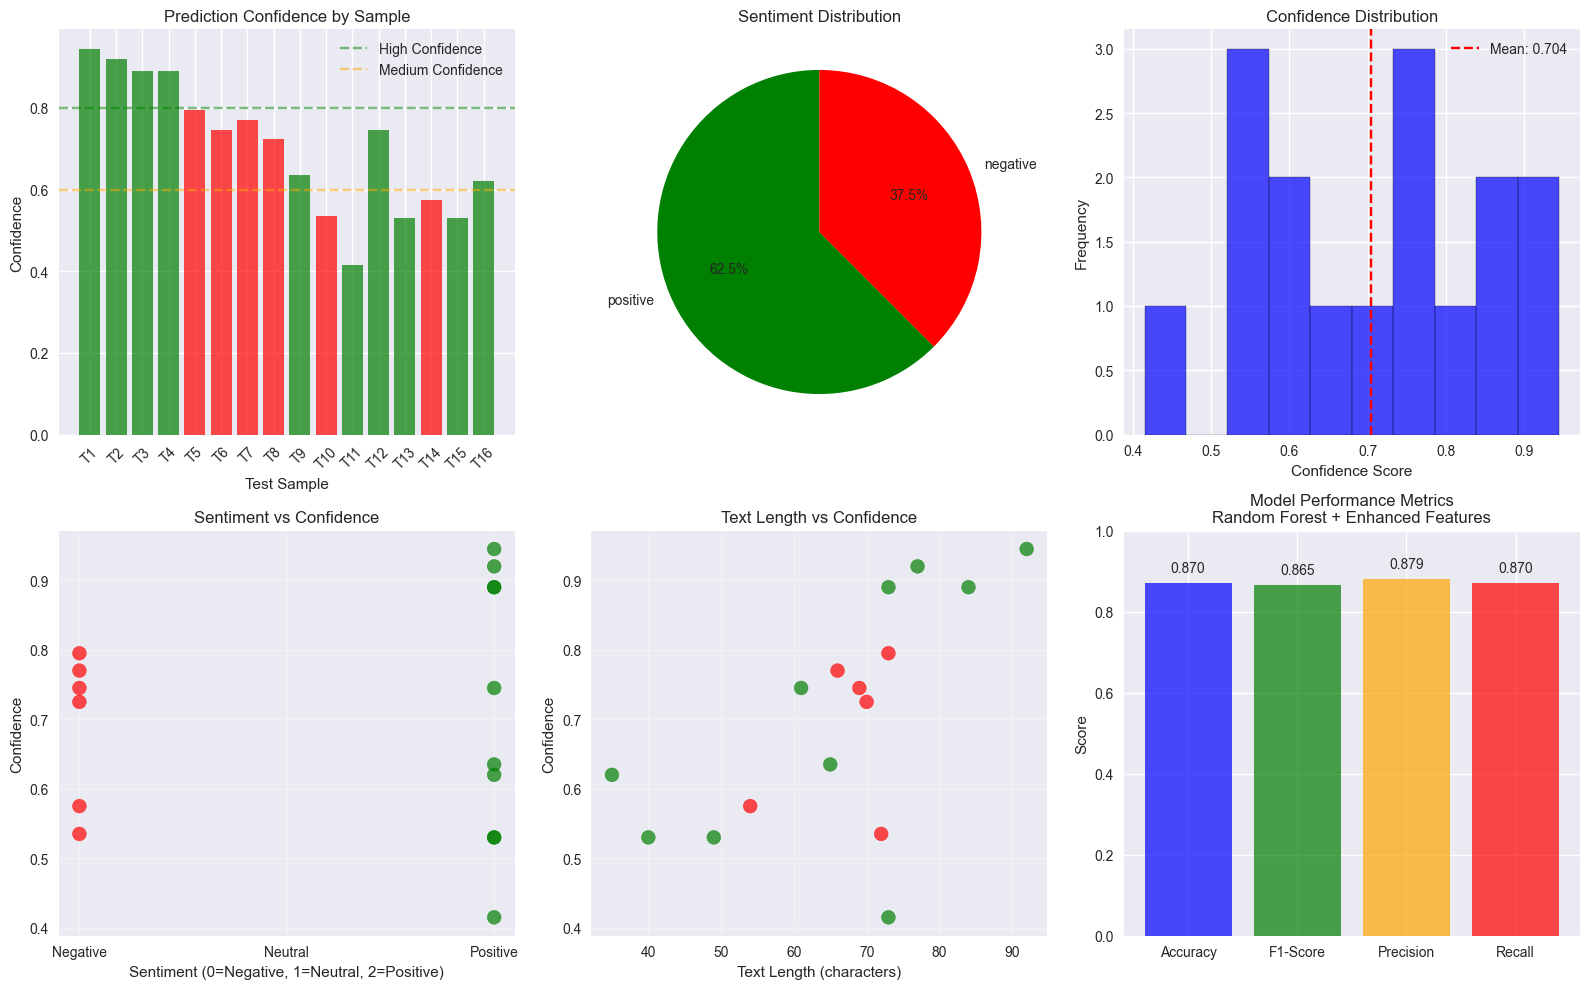


📋 INFERENCE TESTING SUMMARY
✅ Total tests performed: 16
🎯 Model used: Random Forest + Enhanced Features
📊 Model accuracy: 0.8698 (87.0%)
🎪 Average confidence: 0.704
🎭 Sentiment distribution: {'positive': np.int64(10), 'negative': np.int64(6)}
⚡ High confidence predictions: 4/16 (25.0%)
⚠️ Low confidence predictions need review: 5

🎉 Inference system successfully tested with the best model!


In [43]:
# Enhanced test the inference system
print("🧪 COMPREHENSIVE INFERENCE TESTING")
print("=" * 60)

# Extended test samples covering various scenarios
test_reviews = [
    # Clearly Positive
    "I absolutely love Spotify! The music quality is amazing and the recommendations are perfect.",
    "Best music streaming service ever! Great playlists and easy to use interface.",
    "Fantastic app with incredible features. The sound quality is outstanding!",
    "Perfect app for music lovers. Amazing playlist recommendations and smooth interface.",
    
    # Clearly Negative  
    "Terrible app! Keeps crashing and the ads are so annoying. Waste of money.",
    "Spotify sucks! Poor audio quality and too expensive for what you get.",
    "Worst music app ever. Constant bugs and terrible customer service.",
    "Horrible experience! App crashes frequently and premium is overpriced.",
    
    # Neutral/Mixed
    "Spotify is okay, nothing special. Works fine but could be better.",
    "The app is decent but has some bugs. Sometimes it doesn't load properly.",
    "Average experience. Not bad but not great either. Could use improvements.",
    "It's an alright app. Some good features but also some issues.",
    
    # Edge cases
    "Spotify premium ads free music streaming",  # Short, keyword-heavy
    "Love the music but hate the price and ads are annoying",  # Mixed sentiment
    "Used to be great but recent updates made it worse",  # Temporal sentiment
    "Good app but expensive subscription",  # Brief with mixed sentiment
]

print(f"📝 Testing {len(test_reviews)} diverse review samples...")
print(f"🤖 Using model: {predictor.model_name}")

# Predict sentiments
predictions = predictor.predict_batch(test_reviews)

# Display results with enhanced formatting
print("\n" + "="*80)
print("🎯 PREDICTION RESULTS")
print("="*80)

for i, pred in enumerate(predictions):
    # Color coding and emoji based on sentiment
    if pred['sentiment'] == 'positive':
        emoji = "🟢"
        color_desc = "POSITIVE"
    elif pred['sentiment'] == 'negative':
        emoji = "🔴"
        color_desc = "NEGATIVE"
    else:
        emoji = "🟡"
        color_desc = "NEUTRAL"
    
    # Confidence level description
    conf = pred['confidence']
    if conf >= 0.9:
        conf_desc = "Very High"
    elif conf >= 0.7:
        conf_desc = "High"
    elif conf >= 0.5:
        conf_desc = "Medium"
    else:
        conf_desc = "Low"
    
    print(f"\n📝 Test {i+1:2d}: {emoji} {color_desc}")
    print(f"Text: {pred['text'][:70]}{'...' if len(pred['text']) > 70 else ''}")
    print(f"Sentiment: {pred['sentiment'].upper()} | Confidence: {conf:.3f} ({conf_desc})")
    
    # Show error if any
    if 'error' in pred:
        print(f"⚠️ Warning: {pred['error']}")
    
    print("-" * 50)

# Comprehensive analysis
print("\n" + "="*80)
print("📊 PREDICTION ANALYSIS")
print("="*80)

# 1. Sentiment distribution
sentiment_counts = pd.Series([p['sentiment'] for p in predictions]).value_counts()
print(f"\n1️⃣ Sentiment Distribution:")
for sentiment, count in sentiment_counts.items():
    percentage = (count / len(predictions)) * 100
    print(f"   {sentiment.capitalize()}: {count} ({percentage:.1f}%)")

# 2. Confidence analysis
confidences = [p['confidence'] for p in predictions]
print(f"\n2️⃣ Confidence Statistics:")
print(f"   Average: {np.mean(confidences):.3f}")
print(f"   Median: {np.median(confidences):.3f}")
print(f"   Min: {np.min(confidences):.3f}")
print(f"   Max: {np.max(confidences):.3f}")
print(f"   Std Dev: {np.std(confidences):.3f}")

# 3. High/Low confidence predictions
high_conf = [p for p in predictions if p['confidence'] >= 0.8]
low_conf = [p for p in predictions if p['confidence'] < 0.6]

print(f"\n3️⃣ Confidence Analysis:")
print(f"   High confidence (≥0.8): {len(high_conf)} predictions")
print(f"   Low confidence (<0.6): {len(low_conf)} predictions")

if low_conf:
    print(f"\n⚠️ Low Confidence Predictions:")
    for i, pred in enumerate(low_conf[:3]):  # Show top 3
        print(f"   {i+1}. \"{pred['text'][:50]}...\" → {pred['sentiment']} ({pred['confidence']:.3f})")

# 4. Model performance insights
print(f"\n4️⃣ Model Performance:")
print(f"   Model: {predictor.model_name}")
print(f"   Test Accuracy: {best_model['accuracy']:.4f}")
print(f"   Errors: {len([p for p in predictions if 'error' in p])} / {len(predictions)}")

# Enhanced visualization
plt.figure(figsize=(16, 10))

# 1. Prediction confidence by sample
plt.subplot(2, 3, 1)
colors = ['red' if s == 'negative' else 'gray' if s == 'neutral' else 'green' 
          for s in [p['sentiment'] for p in predictions]]
confidences = [p['confidence'] for p in predictions]
bars = plt.bar(range(len(predictions)), confidences, color=colors, alpha=0.7)
plt.title('Prediction Confidence by Sample')
plt.xlabel('Test Sample')
plt.ylabel('Confidence')
plt.xticks(range(len(predictions)), [f'T{i+1}' for i in range(len(predictions))], rotation=45)
plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='High Confidence')
plt.axhline(y=0.6, color='orange', linestyle='--', alpha=0.5, label='Medium Confidence')
plt.legend()

# 2. Sentiment distribution pie chart
plt.subplot(2, 3, 2)
colors_pie = ['red' if x == 'negative' else 'gray' if x == 'neutral' else 'green' 
              for x in sentiment_counts.index]
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
        colors=colors_pie, startangle=90)
plt.title('Sentiment Distribution')

# 3. Confidence distribution histogram
plt.subplot(2, 3, 3)
plt.hist(confidences, bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.axvline(x=np.mean(confidences), color='red', linestyle='--', 
            label=f'Mean: {np.mean(confidences):.3f}')
plt.legend()

# 4. Sentiment vs Confidence scatter plot
plt.subplot(2, 3, 4)
sentiment_numeric = [0 if p['sentiment'] == 'negative' else 1 if p['sentiment'] == 'neutral' else 2 
                    for p in predictions]
scatter = plt.scatter(sentiment_numeric, confidences, c=colors, alpha=0.7, s=100)
plt.xlabel('Sentiment (0=Negative, 1=Neutral, 2=Positive)')
plt.ylabel('Confidence')
plt.title('Sentiment vs Confidence')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.grid(True, alpha=0.3)

# 5. Text length vs Confidence
plt.subplot(2, 3, 5)
text_lengths = [len(p['text']) for p in predictions]
plt.scatter(text_lengths, confidences, c=colors, alpha=0.7, s=100)
plt.xlabel('Text Length (characters)')
plt.ylabel('Confidence')
plt.title('Text Length vs Confidence')
plt.grid(True, alpha=0.3)

# 6. Model comparison (if we have model info)
plt.subplot(2, 3, 6)
model_metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
model_values = [best_model['accuracy'], best_model['f1_score'], 
                best_model['precision'], best_model['recall']]
bars = plt.bar(model_metrics, model_values, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
plt.title(f'Model Performance Metrics\n{predictor.model_name}')
plt.ylabel('Score')
plt.ylim(0, 1)
for i, v in enumerate(model_values):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Summary report
print("\n" + "="*80)
print("📋 INFERENCE TESTING SUMMARY")
print("="*80)
print(f"✅ Total tests performed: {len(predictions)}")
print(f"🎯 Model used: {predictor.model_name}")
print(f"📊 Model accuracy: {best_model['accuracy']:.4f} ({best_model['accuracy']*100:.1f}%)")
print(f"🎪 Average confidence: {np.mean(confidences):.3f}")
print(f"🎭 Sentiment distribution: {dict(sentiment_counts)}")
print(f"⚡ High confidence predictions: {len(high_conf)}/{len(predictions)} ({len(high_conf)/len(predictions)*100:.1f}%)")

if len(low_conf) > 0:
    print(f"⚠️ Low confidence predictions need review: {len(low_conf)}")
else:
    print(f"✅ All predictions have acceptable confidence levels")

print(f"\n🎉 Inference system successfully tested with the best model!")

In [48]:
# Enhanced interactive testing function
def interactive_sentiment_test():
    """Enhanced interactive function for testing custom reviews"""
    print("\n🎮 INTERACTIVE SENTIMENT TESTING")
    print("=" * 60)
    print(f"🤖 Using best model: {predictor.model_name}")
    print(f"📊 Model accuracy: {best_model['accuracy']:.4f} ({best_model['accuracy']*100:.1f}%)")
    print("\nEnter your own review text to test the sentiment analysis!")
    print("Commands:")
    print("  - Type 'quit' or 'exit' to stop")
    print("  - Type 'help' for usage tips")
    print("  - Type 'stats' to see session statistics")
    print("  - Type 'batch' to test multiple reviews at once")
    print("\n" + "-"*60)
    
    # Session statistics
    session_stats = {
        'total_tests': 0,
        'predictions': [],
        'sentiments': {'positive': 0, 'neutral': 0, 'negative': 0}
    }
    
    while True:
        user_input = input("\n💬 Enter review text (or command): ").strip()
        
        # Handle commands
        if user_input.lower() in ['quit', 'exit', 'q']:
            print("\n👋 Thanks for testing!")
            print(f"📊 Session Summary: {session_stats['total_tests']} tests performed")
            if session_stats['total_tests'] > 0:
                for sentiment, count in session_stats['sentiments'].items():
                    percentage = (count / session_stats['total_tests']) * 100
                    print(f"   {sentiment.capitalize()}: {count} ({percentage:.1f}%)")
            break
            
        elif user_input.lower() == 'help':
            print("\n📚 USAGE TIPS:")
            print("• Try different types of reviews (positive, negative, neutral)")
            print("• Test edge cases: very short texts, mixed sentiments, etc.")
            print("• The model works best with natural, conversational text")
            print("• Confidence scores indicate model certainty (higher = more confident)")
            print("• Try reviews about: music quality, app features, pricing, bugs, etc.")
            continue
            
        elif user_input.lower() == 'stats':
            print(f"\n📊 SESSION STATISTICS:")
            print(f"Total tests: {session_stats['total_tests']}")
            if session_stats['total_tests'] > 0:
                avg_conf = np.mean([p['confidence'] for p in session_stats['predictions']])
                print(f"Average confidence: {avg_conf:.3f}")
                print("Sentiment breakdown:")
                for sentiment, count in session_stats['sentiments'].items():
                    percentage = (count / session_stats['total_tests']) * 100
                    print(f"  {sentiment.capitalize()}: {count} ({percentage:.1f}%)")
            continue
            
        elif user_input.lower() == 'batch':
            print("\n📝 BATCH TESTING MODE")
            print("Enter multiple reviews separated by semicolons (;)")
            batch_input = input("Reviews: ").strip()
            if batch_input:
                reviews = [r.strip() for r in batch_input.split(';') if r.strip()]
                if reviews:
                    print(f"\n🔄 Processing {len(reviews)} reviews...")
                    batch_results = predictor.predict_batch(reviews)
                    
                    print("\n📋 BATCH RESULTS:")
                    for i, result in enumerate(batch_results):
                        emoji = "🟢" if result['sentiment'] == 'positive' else "🔴" if result['sentiment'] == 'negative' else "🟡"
                        print(f"{i+1}. {emoji} {result['sentiment'].upper()} ({result['confidence']:.3f})")
                        print(f"   \"{result['text'][:60]}{'...' if len(result['text']) > 60 else ''}\"")
                    
                    # Update session stats
                    for result in batch_results:
                        session_stats['predictions'].append(result)
                        session_stats['sentiments'][result['sentiment']] += 1
                        session_stats['total_tests'] += 1
            continue
        
        # Validate input
        if len(user_input) < 3:
            print("⚠️ Please enter a longer review (at least 3 characters)")
            continue
        
        try:
            # Predict sentiment
            print("🔄 Analyzing sentiment...", end='')
            result = predictor.predict_sentiment(user_input)
            print("\r" + " "*30 + "\r", end='')  # Clear loading message
            
            # Display results with enhanced formatting
            print(f"\n🎯 PREDICTION RESULT:")
            print("=" * 50)
            print(f"📝 Original text: {result['text']}")
            if len(result['processed_text']) != len(result['text']):
                print(f"🧹 Processed: {result['processed_text']}")
            
            # Sentiment with visual indicator
            sentiment = result['sentiment'].upper()
            confidence = result['confidence']
            
            if result['sentiment'] == 'positive':
                print(f"💭 Sentiment: 🟢 {sentiment}")
            elif result['sentiment'] == 'negative':
                print(f"💭 Sentiment: 🔴 {sentiment}")
            else:
                print(f"💭 Sentiment: 🟡 {sentiment}")
            
            # Confidence with interpretation
            if confidence >= 0.9:
                conf_desc = "Very High 🎯"
            elif confidence >= 0.7:
                conf_desc = "High ✅"
            elif confidence >= 0.5:
                conf_desc = "Medium ⚠️"
            else:
                conf_desc = "Low ❓"
            
            print(f"📊 Confidence: {confidence:.3f} ({conf_desc})")
            print(f"🤖 Model: {result['model_used']}")
            
            # Additional insights
            if confidence < 0.6:
                print("💡 Note: Low confidence suggests the text may be ambiguous or the model is uncertain")
            
            if 'error' in result:
                print(f"⚠️ Warning: {result['error']}")
            
            # Update session statistics
            session_stats['predictions'].append(result)
            session_stats['sentiments'][result['sentiment']] += 1
            session_stats['total_tests'] += 1
            
        except Exception as e:
            print(f"\n❌ Error during prediction: {str(e)}")
            print("🔄 Please try again with different text")

# Run enhanced interactive testing
interactive_sentiment_test()


🎮 INTERACTIVE SENTIMENT TESTING
🤖 Using best model: Random Forest + Enhanced Features
📊 Model accuracy: 0.8698 (87.0%)

Enter your own review text to test the sentiment analysis!
Commands:
  - Type 'quit' or 'exit' to stop
  - Type 'help' for usage tips
  - Type 'stats' to see session statistics
  - Type 'batch' to test multiple reviews at once

------------------------------------------------------------
                              
🎯 PREDICTION RESULT:
📝 Original text: I absolutely love Spotify, there's not a whole ton of ads for me and I can still listen for free. I like the Spotify wrapped feature at the end of the year and I love the fact you can see your top songs and artists. Also the mixes are just amazing that they make including all my favorite songs and a few new and suggested ones!
🧹 Processed: absolutely love spotify not whole ton ads still listen free like spotify wrapped feature end year love fact see top songs artists also mixes amazing make including favorite songs 